In [821]:
import math
import pygmo as pg
import numpy as np
import scipy.signal
import math
import scipy.linalg
import scipy.optimize
from scipy.optimize import minimize, OptimizeResult, basinhopping
from optim.problem import SignalProcessingParams
import matplotlib.pyplot as plt
from SALib.sample import latin
from SALib.analyze import rbd_fast
from SALib import ProblemSpec
import pandas as pd
from pykmd.libs.dmd import dmd_rx
from pykmd.libs.lift import blocked_hankel_lift
from pykmd.libs.datclass import Procedure, RefineRitz, RrrInput, RrrOutput, Scaling, RankMode, WeightsScheme, Balancing
from pykmd.kmd import StreamingKmdModel
from sklearn.preprocessing import QuantileTransformer, PowerTransformer, RobustScaler, MinMaxScaler, StandardScaler, Normalizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from dataclasses import dataclass
import itertools
from statsmodels.tsa.seasonal import STL
import statsmodels.api as sm
import time
import seaborn as sns

# Seaborn style for presentation
sns.set_theme(context='notebook', style='whitegrid', palette='deep', font='sans-serif', font_scale=1.5, color_codes=True, rc=None)
# Turn on grid for all plots
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.axisbelow'] = True
plt.rc('axes', axisbelow=True)

## Sensitivity analysis

In [2]:
# Create problem instance (load data and prepare for optimization/sensitivity)
prob = pg.problem(SignalProcessingParams(measure_position=3))
print(prob)
prob_extract = prob.extract(SignalProcessingParams)
# print(prob_extract.file_names)
# fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 10))
# ax[0].plot(prob_extract.grip_dat[10].ravel())
# ax[1].plot(prob_extract.emg_dat[10].ravel())

Problem name: Optimize EMG signal processing parameters to cross-corelate with grip force
	C++ class name: pybind11::object

	Global dimension:			103
	Integer dimension:			1
	Fitness dimension:			1
	Number of objectives:			1
	Equality constraints dimension:		0
	Inequality constraints dimension:	0
	Lower bounds: [0, 0, 0, 0, 0, ... ]
	Upper bounds: [0.1, 0.2, 0.4, 0.5, 1, ... ]
	Has batch fitness evaluation: false

	Has gradient: false
	User implemented gradient sparsity: false
	Has hessians: false
	User implemented hessians sparsity: false

	Fitness evaluations: 0

	Thread safety: none

Extra info:
	Sampling rate: 992.969696969697 Hz
	FFT window size: 496 samples
	FFT resolution: 2.0019550342130987 Hz



In [3]:
prob_extract.get_bounds()[1][176//2-1]

6.5

### Input variables and Problem definition

In [3]:
# Decision vector parameter names using FFT frequencies + decay factor and smoothing window size
param_names = list(np.round(prob_extract.emg_fft_freq[1:], decimals=2))
param_names = ['f' + str(i) for i in param_names] + ['decay', 'window']
param_names = [i.replace('.', '_') for i in param_names]

# Wrapper for evaluation function
def corr_eval(X: np.ndarray, func = prob) -> np.ndarray:
    # import numpy as np
    
    # Iterate over the sample rows (decision vectors) and evaluate the fitness function
    results = np.fromiter(
        iter=(func.fitness(i) for i in X),
        dtype=np.float64, 
        count=X.shape[0]
        )
    return 1. - results.ravel()

# Define the sensitivity problem model
sensitivity_problem = ProblemSpec({
    # 'num_vars': len(param_names),
    # 'groups': ['freqs'] * (len(param_names)-2) + ['decay', 'window'],
    'names': param_names,
    # Get bounds from the problem instance, just reframe in [low, high] format
    'bounds': [[low, up] for low, up in zip(*prob_extract.get_bounds())],
    'outputs': ['corr'],
})

In [4]:
print(repr(sensitivity_problem))

{'names': ['f2_0', 'f4_0', 'f6_01', 'f8_01', 'f10_01', 'f12_01', 'f14_01', 'f16_02', 'f18_02', 'f20_02', 'f22_02', 'f24_02', 'f26_03', 'f28_03', 'f30_03', 'f32_03', 'f34_03', 'f36_04', 'f38_04', 'f40_04', 'f42_04', 'f44_04', 'f46_04', 'f48_05', 'f50_05', 'f52_05', 'f54_05', 'f56_05', 'f58_06', 'f60_06', 'f62_06', 'f64_06', 'f66_06', 'f68_07', 'f70_07', 'f72_07', 'f74_07', 'f76_07', 'f78_08', 'f80_08', 'f82_08', 'f84_08', 'f86_08', 'f88_09', 'f90_09', 'f92_09', 'f94_09', 'f96_09', 'f98_1', 'f100_1', 'f102_1', 'f104_1', 'f106_1', 'f108_11', 'f110_11', 'f112_11', 'f114_11', 'f116_11', 'f118_12', 'f120_12', 'f122_12', 'f124_12', 'f126_12', 'f128_13', 'f130_13', 'f132_13', 'f134_13', 'f136_13', 'f138_13', 'f140_14', 'f142_14', 'f144_14', 'f146_14', 'f148_14', 'f150_15', 'f152_15', 'f154_15', 'f156_15', 'f158_15', 'f160_16', 'f162_16', 'f164_16', 'f166_16', 'f168_16', 'f170_17', 'f172_17', 'f174_17', 'f176_17', 'f178_17', 'f180_18', 'f182_18', 'f184_18', 'f186_18', 'f188_18', 'f190_19', 'f19

In [5]:
(
    # Generate samples and evaluate model in parallel
    sensitivity_problem.sample_latin(N=10000)
    .evaluate(corr_eval, nprocs=6)
)
param_values = sensitivity_problem.samples
print(f"Parameter samples: {param_values.shape}")

corrs = sensitivity_problem.results
print(f"Model evaluations: {corrs.shape}")

/home/tomislav/bin/miniconda3/envs/evoloptim/lib/python3.10/site-packages/SALib/util/problem.py:210: UserWarning: Parallel evaluation is an experimental feature and may not work.
  warnings.warn(


Parameter samples: (10000, 250)
Model evaluations: (10000,)


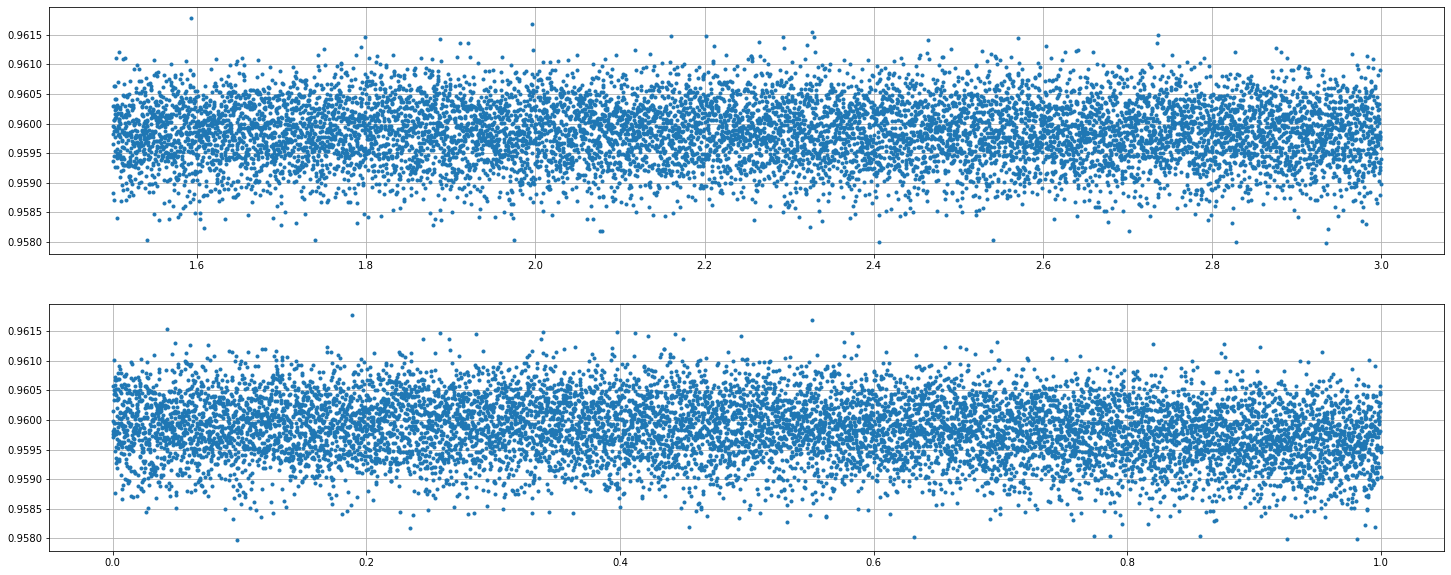

In [6]:
# Convert results to pandas
lh_evaluate = pd.DataFrame(
    np.hstack((param_values, corrs[:, np.newaxis])), 
    columns=[*param_names, 'corrs']
    )

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(25, 10))
# Window size vs correlation
ax[0].plot(lh_evaluate.f58_06, lh_evaluate.corrs, '.')
# ax.set_xlim([0.0, 2])
# ax.set_ylim([0.9, 0.95])
# Decay factor vs correlation
ax[1].plot(lh_evaluate.f10_01, lh_evaluate.corrs, '.')
# ax[1].set_ylim([0.85, 0.93])
# ax.grid()
for a in ax:
    a.grid()

In [7]:
# Export results to csv
lh_evaluate.to_csv('results/sensitivity_preliminary_lh_pos4_narrow22.csv', index=False)

### Validating optimal mask values

In [4]:
# Loading optimal mask
opt_mask = pd.read_csv('data/spectral_mask_optimal.csv')
display(opt_mask)
opt_mask_vals = opt_mask['mask'].to_numpy()

,vars,mask
0,2,0.05000
1,4,0.10000
2,6,0.20000
3,8,0.25000
4,10,0.50000
...,...,...
98,198,5.25000
99,200,5.25000
100,202,5.25000
101,decay,0.00025


In [68]:
# opt_mask_vals[0:2] = 0.
# opt_mask_vals[94:101] = 0.
# opt_mask.iloc[94]

vars    190
mask    0.0
Name: 94, dtype: object

In [5]:
proc_data = prob_extract.process_store_emg_corrs(opt_mask_vals)

### Data estimation and preprocessing functions

In [98]:
def block_hankel_lift(observables: np.ndarray, delay: int, thin_hankel: int = 1) -> np.ndarray:
    """Block hankel lift for observables - time delay embedding."""
    # HAs to be 2D array, convert if not
    if observables.ndim == 1:
        observables = observables.reshape(1, -1)
    obs_num = observables.shape[0]
    # Create hankel for each observable (list of arrays)
    # Function accepts first column and last row
    hankel_concat = [
        scipy.linalg.hankel(observables[i, :][:delay+1], observables[i, :][delay:])
        for i in range(obs_num)
        ]
    # Create a block hankel from each hankel
    block_hankel = []
    # State + delays
    for row in range(delay+1):
        # Observables
        for obs_n in range(obs_num):
            block_hankel.append(hankel_concat[obs_n][row])
    # Thin the block hankel but keep last snapshot
    block_hankel = np.array(block_hankel)[:, ::-1][:, ::thin_hankel][:, ::-1]
    return block_hankel

@dataclass(slots=True)
class StaticKoopmanInput:
    observables: np.ndarray
    lin_trans: np.ndarray

In [7]:
class PlateauShrinkerCompensator(BaseEstimator, TransformerMixin):
    def __init__(
        self, std_cutoff: float = 2, zero_plateau_cutoff: float = 0.05, 
        shrinking_factor: float = 0.5, min_wnd_ratio=0.7, copy=True
        ):
        """Assign input data to bands [0, 1]. Use halfway between band-divisions to assign
        values. Shrink values in bands closer to the band mean value. Compensate for 
        differences between emg and grip bands by adding band_mean * shrinking_factor to 
        shrunk band values. Input X values should ALWAYS be normalized to [0, 1] range.

        Args:
            median_threshold (float, optional): Defaults to 0.4.
            shrinking_factor (float, optional): Between 0 and 1. Lower values, 
            more shrinking. Defaults to 0.5.
            copy (bool, optional): Data is always copied. Defaults to True.
        """
        self.std_cutoff = std_cutoff
        self.zero_plateau_cutoff = zero_plateau_cutoff
        self.shrinking_factor = shrinking_factor
        self.min_wnd_ratio = min_wnd_ratio
        self.grip_normalizer = MinMaxScaler(feature_range=(0, 1))
        self.emg_normalizer = MinMaxScaler(feature_range=(0, 1))

    @staticmethod
    def find_rest_cutoffs(grip, min_wnd_ratio=0.7, std_cutoff=2):
        # Grip data must be unnormalized
        # Find cutoff values after first rest position in grip signal

        # 3 rest positions should be in the entire signal
        # Adapt window size based on total number of points near rest positions
        # Use 60% of 1/3 of total number of points
        min_wnd = round(grip[np.logical_and(grip > -2, grip < 8)].shape[0] / 3 * min_wnd_ratio)
        gr_wnd = []
        gr_cutoff = []
        ind_cutoff = []
        cutoff_num = 0
        for i, gr in enumerate(grip):
            # Make sure that first point added belongs to the rest plateau (0 < gr < 4)
            if not -2 < gr < 8:
                continue
            # Continue if window is < minimum size
            if len(gr_wnd) < min_wnd:
                gr_wnd.append(gr)
                emg_wnd_sd = np.std(gr_wnd)
                emg_wnd_mean = np.mean(gr_wnd)
                continue
            # Compute low and up thresholds using mean and +- 3 sd
            low, up = emg_wnd_mean - std_cutoff * emg_wnd_sd, emg_wnd_mean + std_cutoff * emg_wnd_sd
            # Stop iterating when three cutoff values are found
            if gr < low or gr > up:
                gr_cutoff.append(gr)
                ind_cutoff.append(i)
                cutoff_num += 1
                # Reset window
                gr_wnd = []
                if cutoff_num == 3:
                    break
            else:
                # Append to window
                gr_wnd.append(gr)
                # Update mean and sd
                emg_wnd_sd = np.std(gr_wnd)
                emg_wnd_mean = np.mean(gr_wnd)
        return (ind_cutoff, gr_cutoff)

    @staticmethod
    def find_plateaus_hist(normalized_signal, indice_cutoffs, zero_plateau_cutoff=0.05):
        # Find plateaus in signal using histogram method.
        # Expand indice bounds to include beginning and end of signal
        ind_cut_bounds = np.hstack((0, indice_cutoffs, len(normalized_signal)))
        plateaus = []
        for i in range(len(ind_cut_bounds)-1):
            hist = np.histogram(
                normalized_signal[ind_cut_bounds[i]:ind_cut_bounds[i+1]],
                bins='doane', density=False
                )
            # Compute average bin value from low and high bin edges
            average_bin = (hist[1][1:] + hist[1][:-1]) / 2
            # Find maximum value in histogram with values larger then zero_plateau_cutoff
            plateau_mask = average_bin > zero_plateau_cutoff
            plateau_ind = np.argmax(hist[0][plateau_mask])
            plateaus.append(average_bin[plateau_mask][plateau_ind])

        # Add zero level plateau to global plateaus
        plateaus.append(np.median(normalized_signal[normalized_signal <= zero_plateau_cutoff]))
        return np.array(plateaus)
    
    def shrink_rest_plateaus(self, X):
        # Plateaus should be sorted, so index 0 is the lowest plateau
        # Shrink values twice larger than the lowest plateau and lower
        # X[X < self.plateaus_emg[0]*2] *= self.shrinking_factor
        X[X <= self.zero_plateau_cutoff] *= self.shrinking_factor
        return X
    
    @staticmethod
    def fit_func(x, a, b):
        # Fit function for correction of plateaus
        return a * x**b
    
    def fit(self, X, y=None):
        self.rest_ind_cutoff, gr_cut = self.find_rest_cutoffs(
            grip=y.ravel(), std_cutoff=self.std_cutoff, min_wnd_ratio=self.min_wnd_ratio
            )
        # print(f"Rest plateau cutoffs: {self.rest_ind_cutoff}")  
        emg_proc_trans = self.emg_normalizer.fit_transform(X).ravel()
        grip_trans = self.grip_normalizer.fit_transform(y).ravel()
        # TODO: Find plateaus in EMG signal, but decompose signal using STL, 
        # TODO: and find plateaus in trend only
        emg_proc_trans_trend = STL(
            emg_proc_trans, period=1000, seasonal=1001, trend=1501,
        ).fit().trend
        self.plateaus_emg = self.find_plateaus_hist(
            emg_proc_trans_trend, self.rest_ind_cutoff, zero_plateau_cutoff=self.zero_plateau_cutoff
            )
        # print(f"Plateaus emg: {self.plateaus_emg}")
        # Shrink rest plateaus and find them again
        emg_proc_trans_trend = self.shrink_rest_plateaus(emg_proc_trans_trend)
        self.plateaus_emg = self.find_plateaus_hist(
            emg_proc_trans_trend, self.rest_ind_cutoff, zero_plateau_cutoff=self.zero_plateau_cutoff
            )
        self.plateaus_emg.sort()
        # print(f"Plateaus emg: {self.plateaus_emg}")
        self.plateaus_grip = self.find_plateaus_hist(
            grip_trans, self.rest_ind_cutoff, zero_plateau_cutoff=self.zero_plateau_cutoff
            )
        self.plateaus_grip.sort()
        # print(f"Plateaus grip: {self.plateaus_grip}")
        self.coeffs, _ = scipy.optimize.curve_fit(
            self.fit_func, self.plateaus_emg, self.plateaus_grip,
            bounds=([0, 0], [1.5, 1.5])
            )
        # print(f"Fit coefficients: {self.coeffs}")
        # Correction function
        self.correct_func = lambda x: self.fit_func(x, *self.coeffs)
        # Corrected plateaus
        self.plateaus_emg_corrected = self.correct_func(self.plateaus_emg)
        return self

    def transform(self, X: np.ndarray, y=None):
        # Normalize using fitted normalizer
        X_transformed = self.emg_normalizer.transform(X)
        # Shrink rest plateaus
        X_transformed = self.shrink_rest_plateaus(X_transformed)
        # Correct all values using polynomial correctino function
        X_transformed = self.correct_func(X_transformed)
        # Rescale to [0, 1]
        X_transformed = self.emg_normalizer.transform(X_transformed)
        return X_transformed

class StaticKoopmanBagging:
    def __init__(self, emg_proc: np.ndarray, grip: np.ndarray, dat_step: int):
        self.emg_proc = emg_proc
        self.grip = grip
        self.dat_step = dat_step
        self.koopman_operators = []

    def fit(
        self, num_bootstrap_samples: int = 5, zero_plateau_cutoff: float = 0.05, 
        shrinking_factor: float = 0.5, num_delays: int = 90
        ):
        self.num_delays = num_delays
        self.zero_plateau_cutoff = zero_plateau_cutoff
        self.shrinking_factor = shrinking_factor
        self.koopman_operators = []
        self.grip_approx = np.zeros_like(self.grip[::self.dat_step])

        self.transformer_emg = Pipeline([
            ('PlateauCompensator', PlateauShrinkerCompensator(
                std_cutoff=2, zero_plateau_cutoff=self.zero_plateau_cutoff,
                shrinking_factor=self.shrinking_factor)),
            ('MinMaxGrip', MinMaxScaler(
                feature_range=(
                    self.grip[::self.dat_step].min(), self.grip[::self.dat_step].max()
                ))),
            ]
            )

        self.transformer_emg.fit(
            X=self.emg_proc[::self.dat_step].reshape(-1, 1),
            y=self.grip[::self.dat_step].reshape(-1, 1)
            )
        emg_proc_trans = self.transformer_emg.transform(
            self.emg_proc[::self.dat_step].reshape(-1, 1)
            ).ravel()
        # Create bootstrap samples
        bootstrap_samples = np.random.choice(
            np.arange(len(self.grip[::self.dat_step])),
            size=(num_bootstrap_samples, len(self.grip[::self.dat_step])),
            replace=True
            )
        # print(f'Bootstrap samples: {bootstrap_samples}')
        # Train all Koopman operators
        for bt_sample in bootstrap_samples:
            # Lift bootstrap sample
            grip_emg_lift = StaticKoopmanInput(
                observables=blocked_hankel_lift(
                    observables=emg_proc_trans[bt_sample].reshape(1, -1), num_delays=self.num_delays
                    ),
                lin_trans=blocked_hankel_lift(
                    observables=self.grip[::self.dat_step][bt_sample].reshape(1, -1), num_delays=self.num_delays
                    ),
                )
            
            self.koopman_operators.append(
                grip_emg_lift.lin_trans @ scipy.linalg.pinv(grip_emg_lift.observables)
                )
            # Lift original data
            grip_emg_lift = StaticKoopmanInput(
                observables=blocked_hankel_lift(
                    observables=emg_proc_trans.reshape(1, -1), num_delays=self.num_delays
                    ),
                lin_trans=blocked_hankel_lift(
                    observables=self.grip[::self.dat_step].reshape(1, -1), num_delays=self.num_delays
                    ),
                )
            # Compute grip approximation - Keep first column and last row of the grid_approx
            grip_approx = self.koopman_operators[-1] @ grip_emg_lift.observables
            grip_approx = np.hstack((grip_approx[0, :], grip_approx[1:, -1])).real
            # Add approximation to the global approximation to compute mean later
            self.grip_approx += grip_approx
        # Compute mean approximation
        self.grip_approx /= num_bootstrap_samples

class StaticKoopmanGradientBoost:
    def __init__(self, emg_proc: np.ndarray, grip: np.ndarray, dat_step: int):
        self.emg_proc = emg_proc
        self.grip = grip
        self.dat_step = dat_step
        self.multipliers = []

    def fit(
        self, max_num_iterations: int = 5, learning_rate: np.ndarray = 0.1,
        multiplier: float = None, multiplier_stop_criteria: float = 0.05,
        zero_plateau_cutoff: float = 0.05, 
        shrinking_factor: float = 0.5, num_delays: int = 90
        ):
        self.num_delays = num_delays
        self.zero_plateau_cutoff = zero_plateau_cutoff
        self.shrinking_factor = shrinking_factor
        koopman_operators = []
        self.multipliers = []

        self.transformer_emg = Pipeline([
            ('PlateauCompensator', PlateauShrinkerCompensator(
                std_cutoff=2, zero_plateau_cutoff=self.zero_plateau_cutoff,
                shrinking_factor=self.shrinking_factor)),
            ('MinMaxGrip', MinMaxScaler(
                feature_range=(
                    self.grip[::self.dat_step].min(), self.grip[::self.dat_step].max()
                ))),
            ]
            )

        self.transformer_emg.fit(
            X=self.emg_proc[::self.dat_step].reshape(-1, 1),
            y=self.grip[::self.dat_step].reshape(-1, 1)
            )
        emg_proc_trans = self.transformer_emg.transform(
            self.emg_proc[::self.dat_step].reshape(-1, 1)
            ).ravel()
        
        grip_emg_lift = StaticKoopmanInput(
            observables=blocked_hankel_lift(
                observables=emg_proc_trans.reshape(1, -1), num_delays=self.num_delays
                ),
            lin_trans=blocked_hankel_lift(
                observables=self.grip[::self.dat_step].reshape(1, -1), num_delays=self.num_delays
                ),
            )
        
        # Initialize gradient boosting regressor with initial Koopman model
        # Compute Koopman operator using pseudoinverse
        # Store initial Koopman operator
        koopman_operators.append(grip_emg_lift.lin_trans @ scipy.linalg.pinv(
            grip_emg_lift.observables
            ))
        # Compute grip approximation - Keep first column and last row of the grid_approx
        self.grip_approx = koopman_operators[-1] @ grip_emg_lift.observables
        self.grip_approx = np.hstack((self.grip_approx[0, :], self.grip_approx[1:, -1])).real

        # Iterate to improve the model
        for _ in range(max_num_iterations):
            # Compute pseudo-residuals
            residuals = self.grip[::self.dat_step] - self.grip_approx

            # Fit a base learner to the residuals
            grip_resid_lift = StaticKoopmanInput(
                observables=blocked_hankel_lift(
                    observables=emg_proc_trans.reshape(1, -1), num_delays=self.num_delays
                    ),
                lin_trans=blocked_hankel_lift(
                    observables=residuals.reshape(1, -1), num_delays=self.num_delays
                    ),
                )
            koopman_operators.append(
                grip_resid_lift.lin_trans @ scipy.linalg.pinv(grip_resid_lift.observables)
                )
            # Compute residual approximation - Keep first column and last row of the grid_approx
            resid_approx = koopman_operators[-1] @ grip_resid_lift.observables
            resid_approx = np.hstack((resid_approx[0, :], resid_approx[1:, -1])).real
            # Compute multiplier gamma
            if not multiplier:
                self.multipliers.append(
                    np.sum(
                        resid_approx * (self.grip[::self.dat_step] - self.grip_approx)
                        ) / 
                    np.sum(resid_approx**2)
                    )
            else:
                self.multipliers.append(multiplier)
            # print(f'Gamma: {self.multipliers[-1]}')
            # Update model
            self.grip_approx += learning_rate * self.multipliers[-1] * resid_approx
            # Stop iterating if multiplier is below threshold
            if np.abs(self.multipliers[-1]) < multiplier_stop_criteria:
                break
        # Compute final (chained) Koopman operator
        self.koopman_operator = koopman_operators[0] + learning_rate * np.sum(
            [gamma * koopman for gamma, koopman in zip(self.multipliers, koopman_operators[1:])],
            axis=0
            )

class BoundsNoLocalMinimization:
    def __init__(self, bounds):
        self.lower_bounds, self.upper_bounds = zip(*bounds)
        # print(f'Lower bounds: {self.lower_bounds}')
        # print(f'Upper bounds: {self.upper_bounds}')
        # Storing x and f values for each iteration
        self.x = []
        self.f = []
        self.accepted = []
    
    def no_minimization(self, fun, x0, args, **options):
        fun_res = fun(x0, *args).ravel()
        return OptimizeResult(x=x0, fun=fun_res, success=True, nfev=1)

    def store_jumps(self, x, f, accepted):
        # Can return True to terminate optimization early
        self.x.append(x)
        self.f.append(f.ravel())
        self.accepted.append(accepted)
        
class TakeStepRutine:
    def __init__(self, bounds, stepsize=0.01):
        self.lower_bounds, self.upper_bounds = zip(*bounds)
        # print(f'Lower bounds: {self.lower_bounds}')
        # print(f'Upper bounds: {self.upper_bounds}')
        self.stepsize = stepsize
        self.rng = np.random.default_rng()

    def __call__(self, x):
        s = self.stepsize
        steps = self.rng.uniform(-s, s, size=x.shape)
        # Increase step for second dimension 7.5 times
        steps[1] *= 7.5
        # Increase step size for third dimension 1.5 times
        steps[2] *= 2.5
        # steps[2] *= 0
        x_new = x + steps
        up_true = bool(np.all(x_new <= self.upper_bounds))
        low_true = bool(np.all(x_new >= self.lower_bounds))
        while not (up_true and low_true):
            # Generate new steps until x are within bounds
            steps = self.rng.uniform(-s, s, size=x.shape)
            steps[1] *= 7
            x_new = x + steps
            up_true = bool(np.all(x_new <= self.upper_bounds))
            low_true = bool(np.all(x_new >= self.lower_bounds))
        return x_new

def construct_grid_obs(
    time_delay_lifted: np.ndarray, 
    grid_div: np.ndarray,
    keep_indices: list = None,
    ) -> tuple[np.ndarray, list]:
    grid_obs = []
    num_delays = time_delay_lifted.shape[0]
    sparsify_indices = []
    for ind, bounds in enumerate(
        itertools.product(np.lib.stride_tricks.sliding_window_view(grid_div, 2), repeat=num_delays)
        ):
        # Skip if index not kept
        if keep_indices and (ind not in keep_indices):
            continue
        # Check all time delays against grid bounds, collapse using all and convert to float (0, 1)
        temp_obs = np.logical_and(
            # 
            time_delay_lifted.T > np.array(bounds)[:, 0], 
            time_delay_lifted.T <= np.array(bounds)[:, 1]
            )
        temp_obs = temp_obs.all(axis=1).astype(float)
        # Check if observable density is at least 0.1 % to keep it
        if (temp_obs.sum() / temp_obs.shape[0]) > 0.001:
        # if (temp_obs.sum() / temp_obs.shape[0]) > 0.000:
            grid_obs.append(temp_obs)
            sparsify_indices.append(ind)
        elif keep_indices and (ind in keep_indices):
            # If index is kept, but all zeros, add zeros to grid_obs
            grid_obs.append(temp_obs)
            sparsify_indices.append(ind)
    return np.array(grid_obs), sparsify_indices

### Grid vizualization

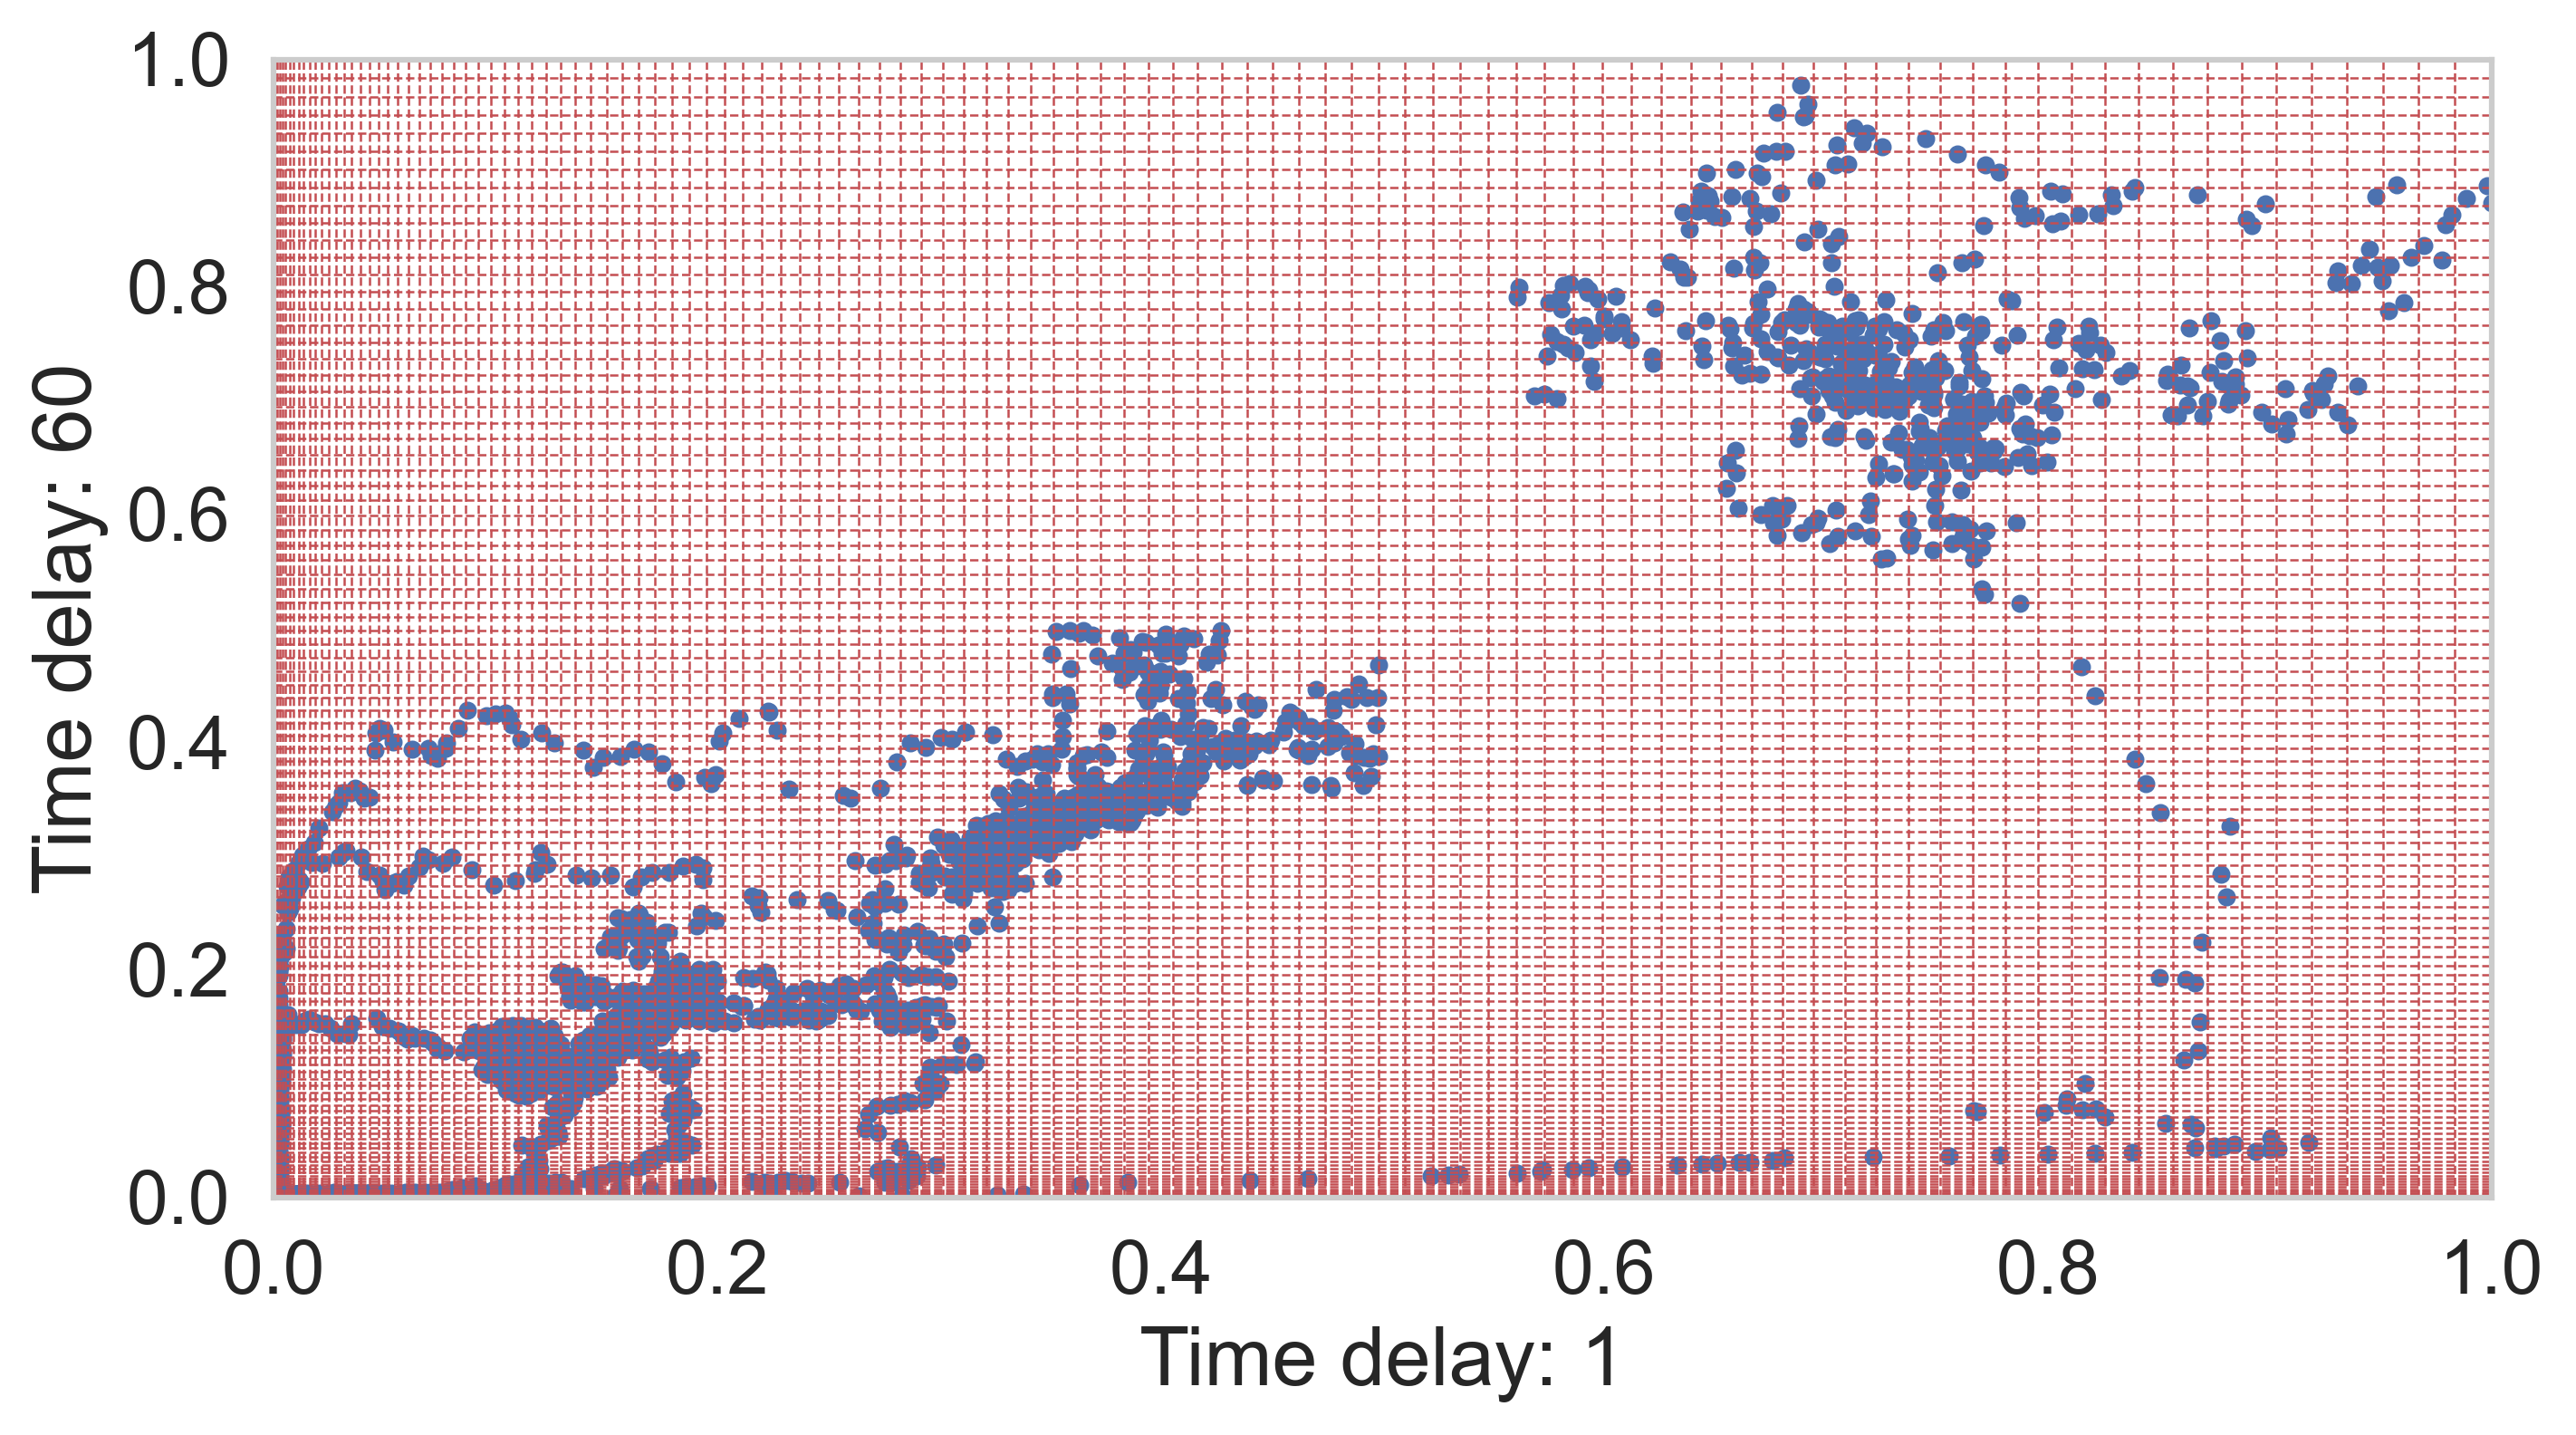

In [39]:
# Get PlateauShrinkerCompensator from Pipeline
# plateau_comp = transformer_emg.named_steps['PlateauCompensator']
# plateau_comp.plateaus_grip
# plateau_comp.plateaus_emg_corrected
# plateau_comp.rest_ind_cutoff
# Grid division based on corrected plateaus
# grid_div = np.diff(plateau_comp.plateaus_emg_corrected)/2 + plateau_comp.plateaus_emg_corrected[:-1]
# Add 0 and 1 to the grid_div
# grid_div = np.hstack((0, grid_div, 1))
num_delays = 60
# grid_td_select = [1, num_delays//2, num_delays]
grid_td_select = [1, num_delays]
# grid_div = np.linspace(0, 1, 10)
# grid_div = np.linspace(0, 1, 22)**1.8
grid_div = np.linspace(0, 1, 110)**1.8
emg_td_embed = blocked_hankel_lift(emg_proc_scaled.reshape(1, -1), num_delays=num_delays)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 4.5), dpi=360)
# fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(7.5, 9), dpi=360)
# for num, td in enumerate(itertools.combinations(grid_td_select, 2)):
#     i, j = td
#     ax[num].plot(emg_td_embed[i], emg_td_embed[j], 'o', markersize=2)
#     ax[num].set_xlabel(f'Time delay: {i}')
#     ax[num].set_ylabel(f'Time delay: {j}')
#     ax[num].set_xlim([0, 1])
#     ax[num].set_ylim([0, 1])
#     ax[num].grid()
#     # ax.plot(plateau_comp.plateaus_emg_corrected, plateau_comp.plateaus_emg_corrected, 'o')
#     for div in grid_div:
#         ax[num].axhline(div, color='r', linestyle='--', linewidth=0.5)
#         ax[num].axvline(div, color='r', linestyle='--', linewidth=0.5)
for i, j in itertools.combinations(grid_td_select, 2):
    ax.plot(emg_td_embed[i], emg_td_embed[j], '.')
    # ax.set_xlabel(f'Time delay: {i}')
    ax.set_ylabel(f'Time delay: {j}')
    ax.set_ylabel(f': {j}')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.grid()
    # ax.plot(plateau_comp.plateaus_emg_corrected, plateau_comp.plateaus_emg_corrected, 'o')
    for div in grid_div:
        ax.axhline(div, color='r', linestyle='--', linewidth=0.5)
        ax.axvline(div, color='r', linestyle='--', linewidth=0.5)
ax.set_xlabel('Time delay: 1')
ax.set_ylabel(f'Time delay: {num_delays}')
plt.tight_layout() 

In [892]:
grid_obs, grid_obs_ind = construct_grid_obs(emg_td_embed[grid_td_select, :], grid_div)
print(grid_obs.shape)
# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(25, 10))
# ax.plot(grid_obs.T)

(272, 2190)


In [948]:
emg_proc.min(), emg_proc.max()

(0.014949239959185486, 0.5182758255377061)

### Grip estimation from EMG

File name: mdp3m1_24_m
Time to process all batches: 0.5599250793457031 s
wMAPE: 4.257982638257215 %
Signal length: 29955
Max correlation: 0.9774419973073193
Correlation lag: 45
Correlation lag [ms]: 45.318603515625


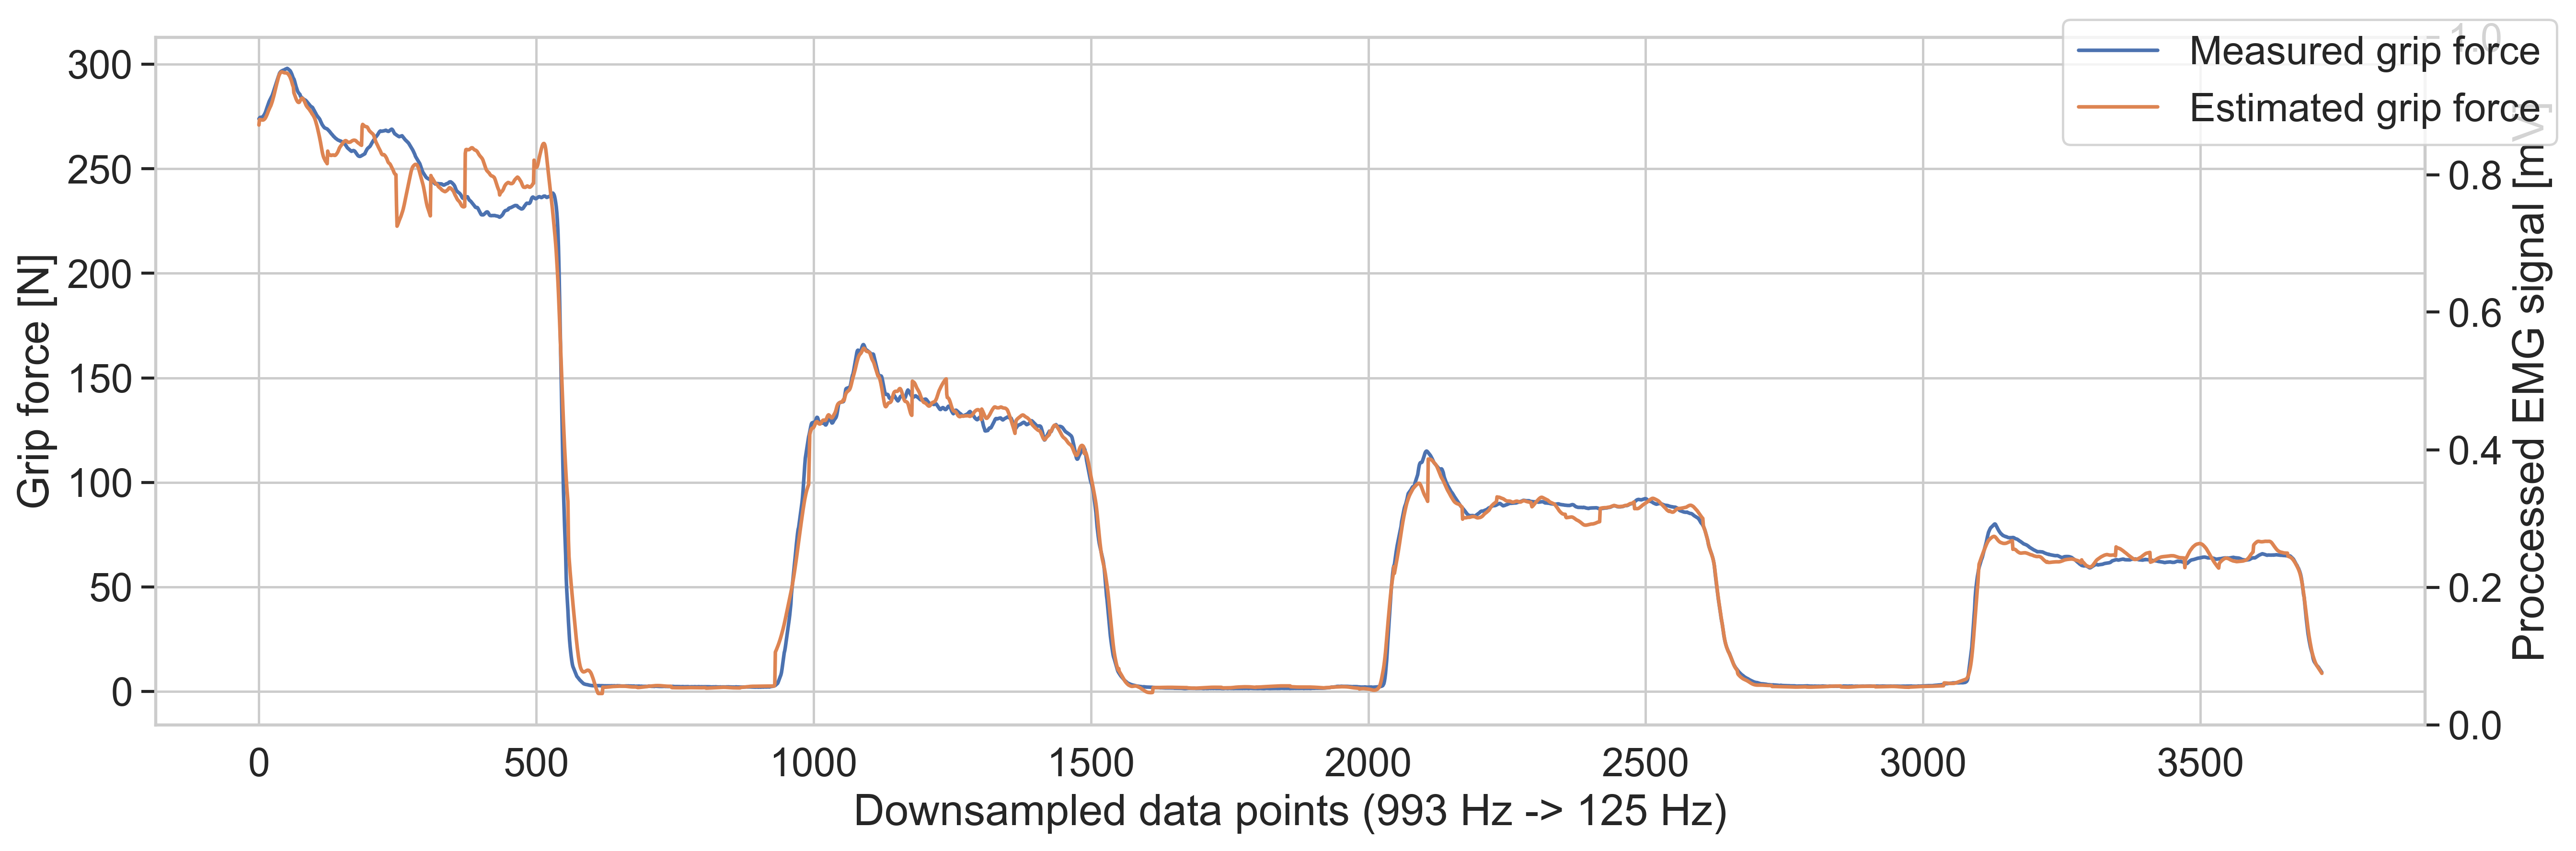

In [8]:
# Specify downsampling step
dat_step = 8
# Number of time delays
num_delays = 60
# Selection of time delays for grid observables
# grid_td_select = [1, num_delays//3, 2*(num_delays//3), num_delays]
grid_td_select = [1, num_delays//2, num_delays]
# grid_td_select = [1, num_delays]
# Slice_to_train Koopman
# slice_train = np.s_[750:3000]
# slice_train = np.s_[:2000]
slice_train = np.s_[:]
# Batch size as parameter
batch_size = 496//dat_step
# id_ind = 25
# id_ind = 2
# id_ind = 4
# id_ind = 15
id_ind = 16
time_t = proc_data['time_t'][id_ind]
emg = proc_data['emg'][id_ind]
emg_proc = proc_data['emg_processed'][id_ind]
grip = proc_data['grip'][id_ind]
corrs = proc_data['corrs'][id_ind]
lags = scipy.signal.correlation_lags(len(emg_proc), len(grip))
print(f'File name: {proc_data["file_names"][id_ind]}')

transformer_emg = Pipeline([
    # ('ZeroOneScaler', MinMaxScaler(feature_range=(emg_proc[::dat_step].min(), emg_proc[::dat_step].max())))
    ('ZeroOneScaler', MinMaxScaler(feature_range=(0, 1)))
    # ('ZeroOneScaler', MinMaxScaler(feature_range=(grip.min(), grip.max())))
    ])
transformer_grip = Pipeline([
    ('ZeroOneScaler', MinMaxScaler(feature_range=(grip[::dat_step].min(), grip[::dat_step].max())))
    # ('ZeroOneScaler', MinMaxScaler(feature_range=(0, 1)))
    ])

emg_proc_scaled = transformer_emg.fit_transform(
    emg_proc[::dat_step][slice_train].reshape(-1, 1), grip[::dat_step][slice_train].reshape(-1, 1)
    ).ravel()
grip_trans = transformer_grip.fit_transform(grip[::dat_step][slice_train].reshape(-1, 1)).ravel()

# Get PlateauShrinkerCompensator from Pipeline
# plateau_comp = transformer_emg.named_steps['PlateauCompensator']
# plateau_comp.plateaus_grip
# plateau_comp.plateaus_emg_corrected
# plateau_comp.rest_ind_cutoff
# Grid division based on corrected plateaus
# grid_div = np.diff(plateau_comp.plateaus_emg_corrected)/2 + plateau_comp.plateaus_emg_corrected[:-1]
# Add 0 and 1 to the grid_div
# grid_div = np.hstack((0, grid_div, 1))
# Use for 2td grid observables - wmape 14.66%
# grid_div = np.linspace(0, 1, 100)**1.8
# USe for 3 td grid observables - wmape  - 9.9 %
# grid_div = np.linspace(emg_proc[::dat_step].min(), emg_proc[::dat_step].max(), 22)**1.8
grid_div = np.linspace(0, 1, 22)**1.8
emg_td_embed = blocked_hankel_lift(
    observables=emg_proc_scaled.reshape(1, -1), num_delays=num_delays
    )
# Use only 2 - 3 state/time delays since number of combinations explodes
grid_obs, grid_obs_ind = construct_grid_obs(emg_td_embed[grid_td_select, :], grid_div)

grip_emg_lift = StaticKoopmanInput(
    observables=np.vstack((
            emg_td_embed,
            grid_obs
            )),
    lin_trans=np.vstack((
        blocked_hankel_lift(grip_trans.reshape(1, -1), num_delays),
        np.zeros_like(grid_obs),
        )),
    )
koopman_operator = grip_emg_lift.lin_trans @ scipy.linalg.pinv(
    grip_emg_lift.observables
    )

# Compute grip approximation on bulk data
emg_proc_blk_stl = []
emg_proc_blk = []
grip_blk_orig = []
grip_blk_approx = []
# Time just the batch processing
batch_proc_start = time.time()
for em_blk, grp_blk in np.nditer([emg_proc, grip], flags=['external_loop', 'buffered'], buffersize=496):
    if em_blk.size < 496 or grp_blk.size < 496:
        continue
    # Downsample EMG signal
    em_blk_dwns = em_blk[::dat_step]
    # Append downsampled grip
    grip_blk_orig.append(transformer_grip.transform(grp_blk[::dat_step].reshape(-1, 1)).ravel())
    emg_blk_trans = transformer_emg.transform(em_blk_dwns.reshape(-1, 1)).ravel()
    emg_proc_blk.append(emg_blk_trans)

    emg_td_embed_blk = blocked_hankel_lift(emg_blk_trans.reshape(1, -1), num_delays=num_delays)
    # Constuct grid observables, but keep indices from learned model on entire dataset
    grid_obs, _ = construct_grid_obs(emg_td_embed_blk[grid_td_select, :], grid_div, keep_indices=grid_obs_ind)
    grip_blk_approx.append(koopman_operator @ np.vstack((
            emg_td_embed_blk,
            grid_obs
            )))
    grip_blk_approx[-1] = np.hstack((grip_blk_approx[-1][0, :], grip_blk_approx[-1][1:num_delays+1, -1])).real
    # Threshold too low values to -1 N if below
    grip_blk_approx[-1][grip_blk_approx[-1] < -1] = -1

batch_proc_duration = time.time() - batch_proc_start
print(f'Time to process all batches: {batch_proc_duration} s')
grip_blk_orig = np.hstack(grip_blk_orig)
emg_proc_blk = np.hstack(emg_proc_blk)
grip_blk_approx = np.hstack(grip_blk_approx)

wmape_est = np.abs(grip_blk_orig - grip_blk_approx).sum() / np.abs(grip_blk_orig).sum() * 100

print(f'wMAPE: {wmape_est} %')

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 5), dpi=360)
# Secondary axis for EMG data
ax2 = ax.twinx()
ax2.grid()
# ax.plot(time_t, emg_proc_scaled)
# ax.plot(emg_proc_scaled)
# ax2.plot(emg_proc_blk, color='g', label='Processed EMG signal')
# ax.plot(grip_trans)
ax.plot(grip_blk_orig, label='Measured grip force')
ax.plot(grip_blk_approx, label='Estimated grip force')

ax.set_xlabel('Downsampled data points (993 Hz -> 125 Hz)')
ax.set_ylabel('Grip force [N]')
ax2.set_ylabel('Proccessed EMG signal [mV]')
fig.legend()
fig.tight_layout()

print(f'Signal length: {len(emg_proc)}')
print(f'Max correlation: {np.max(corrs)}')
print(f'Correlation lag: {lags[np.argmax(corrs)]}')
print(f'Correlation lag [ms]: {lags[np.argmax(corrs)] * 1 / 992.969696969697 * 1e3}')

In [970]:
##### Process all data for single measurement
#### Static Koopman operator with time delays embedding and gridded binary observables
# for mapping processed EMG signal to Grip signal

# Specify downsampling step
dat_step = 8
# Grid divisions - same for all data
grid_div = np.linspace(0, 1, 22)**1.8
# Number of time delays
num_delays = 60
# Selected time delays for binary grid observables
grid_td_select = [1, num_delays//2, num_delays]
# Create new dictionary for data processed in batches and downsampled
# Copy keys from dictionary proc_data and instantiate empty lists
proc_data_blk = {key: [] for key in proc_data.keys()} 
del proc_data_blk['corrs']
proc_data_blk['emg_processed_transformed'] = []
proc_data_blk['grip_approx'] = []
proc_data_blk['max_corr'] = []
proc_data_blk['max_corr_lag'] = []
proc_data_blk['time_delay'] = []
proc_data_blk['rmse'] = []
proc_data_blk['mae'] = []
proc_data_blk['mae_mvc'] = []
proc_data_blk['wmape'] = []
# Iterate over all keys, and obtain approximations and parameters
for id_ind in range(len(proc_data['time_t'])):
# for id_ind in [25]:
# for id_ind in [4]:
    # Load data for specific patient, measurement and position
    file_name = proc_data['file_names'][id_ind]
    proc_data_blk['file_names'].append(file_name)
    print(f'File number: {id_ind}, name: {file_name}')
    time_t = proc_data['time_t'][id_ind]
    emg = proc_data['emg'][id_ind]
    emg_proc = proc_data['emg_processed'][id_ind]
    grip = proc_data['grip'][id_ind]
    corrs = proc_data['corrs'][id_ind]
    proc_data_blk['max_corr'].append(np.max(corrs))
    lags = scipy.signal.correlation_lags(len(emg_proc), len(grip))
    proc_data_blk['max_corr_lag'].append(lags[np.argmax(corrs)])

    
    transformer_emg = MinMaxScaler(feature_range=(0, 1))

    emg_proc_scaled = transformer_emg.fit_transform(emg_proc[::dat_step].reshape(-1, 1)).ravel()
    grip_trans = grip[::dat_step]
    
    emg_td_embed = blocked_hankel_lift(
        observables=emg_proc_scaled.reshape(1, -1), num_delays=num_delays
        )
    # Use only 2 - 3 state/time delays since number of combinations explodes
    grid_obs, grid_obs_ind = construct_grid_obs(emg_td_embed[grid_td_select, :], grid_div)

    grip_emg_lift = StaticKoopmanInput(
        observables=np.vstack((
                emg_td_embed,
                grid_obs
                )),
        lin_trans=np.vstack((
            blocked_hankel_lift(grip_trans.reshape(1, -1), num_delays),
            np.zeros_like(grid_obs),
            )),
        )
    koopman_operator = grip_emg_lift.lin_trans @ scipy.linalg.pinv(
        grip_emg_lift.observables
        )

    # Store optimal parameters
    proc_data_blk['time_delay'].append(num_delays)

    # Approximate entire dataset in bulks of 496 samples - simulating real-time
    grip_blk_approx_full = []
    grip_blk_full = []
    time_t_blk_full = []
    emg_blk_full = []
    emg_proc_blk_full = []
    emg_proc_trans_blk_full = []
    for time_blk, emg_blk, emg_proc_blk, grp_blk in np.nditer(
        [time_t, emg, emg_proc, grip],
        flags=['external_loop', 'buffered'], buffersize=496
        ):
        if emg_blk.size < 496 or grp_blk.size < 496:
            continue
        # Append downsampled time and original emg
        time_t_blk_full.append(time_blk[::dat_step])
        emg_blk_full.append(emg_blk[::dat_step])
        # Downsample EMG signal
        emg_proc_blk_full.append(emg_proc_blk[::dat_step])
        # Append downsampled grip
        grip_blk_full.append(grp_blk[::dat_step])
        emg_proc_trans_blk_full.append(
            transformer_emg.transform(emg_proc_blk_full[-1].reshape(-1, 1)).ravel()
            )

        emg_td_embed_blk = blocked_hankel_lift(
            emg_proc_trans_blk_full[-1].reshape(1, -1), num_delays=num_delays
            )
        # Constuct grid observables, but keep indices from learned model on entire dataset
        grid_obs, _ = construct_grid_obs(
            emg_td_embed_blk[grid_td_select, :], grid_div, keep_indices=grid_obs_ind)
        grip_blk_approx_full.append(koopman_operator @ np.vstack((
                emg_td_embed_blk,
                grid_obs
                )))
        grip_blk_approx_full[-1] = np.hstack((
            grip_blk_approx_full[-1][0, :], grip_blk_approx_full[-1][1:num_delays+1, -1])).real
        # Threshold too low values to -5 N if below
        grip_blk_approx_full[-1][grip_blk_approx_full[-1] < -5] = -5
            
            
    time_t_blk_full = np.hstack(time_t_blk_full)
    emg_blk_full = np.hstack(emg_blk_full)
    emg_proc_blk_full = np.hstack(emg_proc_blk_full)
    emg_proc_trans_blk_full = np.hstack(emg_proc_trans_blk_full)
    grip_blk_full = np.hstack(grip_blk_full)
    grip_blk_approx_full = np.hstack(grip_blk_approx_full)

    proc_data_blk['time_t'].append(time_t_blk_full)
    proc_data_blk['emg'].append(emg_blk_full)
    proc_data_blk['emg_processed'].append(emg_proc_blk_full)
    proc_data_blk['emg_processed_transformed'].append(emg_proc_trans_blk_full)
    proc_data_blk['grip'].append(grip_blk_full)
    proc_data_blk['grip_approx'].append(grip_blk_approx_full)

    # Add error metrics to proc_data_blk
    proc_data_blk['rmse'].append(np.sqrt(np.mean((grip_blk_full - grip_blk_approx_full)**2)))
    proc_data_blk['mae'].append(np.mean(np.abs(grip_blk_full - grip_blk_approx_full)))
    proc_data_blk['mae_mvc'].append(np.mean(np.abs(grip_blk_full - grip_blk_approx_full)) / grip_blk_full.max() * 100)
    proc_data_blk['wmape'].append(np.abs(grip_blk_full - grip_blk_approx_full).sum() / np.abs(grip_blk_full).sum() * 100)
    

    # print(f'RMSE: {proc_data_blk["rmse"][-1]}')
    # print(f'MAE: {proc_data_blk["mae"][-1]}')
    print(f'MAE as %MVC: {proc_data_blk["mae_mvc"][-1]} %')
    print(f'wMAPE: {proc_data_blk["wmape"][-1]} %')

    # Plot approximations
    # fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 5), dpi=360)
    # # Secondary axis for EMG data
    # ax2 = ax.twinx()
    # ax2.grid()
    # # ax.plot(time_t, emg_proc_scaled)
    # # ax.plot(emg_proc_scaled)
    # ax2.plot(emg_proc_blk_full, color='g', label='Processed EMG signal')
    # # ax.plot(grip_trans)
    # ax.plot(grip_blk_full, label='Measured grip force')
    # ax.plot(grip_blk_approx_full, label='Estimated grip force')

    # ax.set_xlabel('Downsampled data points (993 Hz -> 125 Hz)')
    # ax.set_ylabel('Grip force [N]')
    # ax2.set_ylabel('Proccessed EMG signal [mV]')
    # fig.legend()
    # fig.tight_layout()

File number: 0, name: acp4m1_22_m
MAE as %MVC: 1.5873438461674945 %
wMAPE: 4.021056785609119 %
File number: 1, name: acp4m2_22_m
MAE as %MVC: 1.3313103004685811 %
wMAPE: 3.838269792116126 %
File number: 2, name: dpp4m1_23_m
MAE as %MVC: 1.7704628448721018 %
wMAPE: 4.115214490982765 %
File number: 3, name: dpp4m2_23_m
MAE as %MVC: 1.741486576744633 %
wMAPE: 4.310320981378026 %
File number: 4, name: dsp4m1_22_m
MAE as %MVC: 1.8619847936112786 %
wMAPE: 4.695244852183641 %
File number: 5, name: dsp4m2_22_m
MAE as %MVC: 1.7270925995793434 %
wMAPE: 4.439181187757308 %
File number: 6, name: jsp4m1_22_m
MAE as %MVC: 1.445668767130779 %
wMAPE: 3.9441070904747293 %
File number: 7, name: jsp4m2_22_m
MAE as %MVC: 1.840778279979026 %
wMAPE: 5.0775969845898565 %
File number: 8, name: lbp4m1_23_m
MAE as %MVC: 1.2679769464645285 %
wMAPE: 3.2507784752986777 %
File number: 9, name: lbp4m2_23_m
MAE as %MVC: 1.924919005207547 %
wMAPE: 4.91918650787685 %
File number: 10, name: lkp4m1_24_m
MAE as %MVC: 1.70

In [971]:
proc_data_blk

{'file_names': ['acp4m1_22_m',
  'acp4m2_22_m',
  'dpp4m1_23_m',
  'dpp4m2_23_m',
  'dsp4m1_22_m',
  'dsp4m2_22_m',
  'jsp4m1_22_m',
  'jsp4m2_22_m',
  'lbp4m1_23_m',
  'lbp4m2_23_m',
  'lkp4m1_24_m',
  'lkp4m2_24_m',
  'lmp4m1_23_m',
  'lmp4m2_23_m',
  'lnp4m1_23_m',
  'lnp4m2_23_m',
  'mdp4m1_24_m',
  'mdp4m2_24_m',
  'mmp4m1_22_m',
  'mmp4m2_22_m',
  'nkp4m1_23_m',
  'nkp4m2_23_m',
  'pbp4m1_24_m',
  'pbp4m2_24_m',
  'ssp4m1_23_m',
  'ssp4m2_23_m'],
 'time_t': [array([1.71809425e+09, 1.71809425e+09, 1.71809425e+09, ...,
         1.71809428e+09, 1.71809428e+09, 1.71809428e+09]),
  array([1.71809431e+09, 1.71809431e+09, 1.71809431e+09, ...,
         1.71809434e+09, 1.71809434e+09, 1.71809434e+09]),
  array([1.71809788e+09, 1.71809788e+09, 1.71809788e+09, ...,
         1.71809791e+09, 1.71809791e+09, 1.71809791e+09]),
  array([1.71809793e+09, 1.71809793e+09, 1.71809793e+09, ...,
         1.71809796e+09, 1.71809796e+09, 1.71809796e+09]),
  array([1.71809874e+09, 1.71809874e+09, 1.718098

In [972]:
# Create a dataframe and export proc_data to csv
proc_data_df = pd.DataFrame({k: v for k, v in proc_data_blk.items()})
proc_data_df
tot_len = 0
for i in proc_data_df['time_t']:
    tot_len += len(i)
print(f'Total length: {tot_len}')
proc_data_df = proc_data_df.explode(
    ['time_t', 'emg', 'emg_processed', 'emg_processed_transformed', 'grip', 'grip_approx']
    )
proc_data_df
proc_data_df.to_csv('data/processed_approximated_data_dwns8_pos4_td_60_grid_obs.csv', index=False)

Total length: 83328


In [8]:
# Optimization function to return optimal paramters for static Koopman operator - optimize wmape
def static_koopman_wmape(x: np.ndarray, emg_proc: np.ndarray, grip: np.ndarray, dat_step: int) -> float:
    """
    Args:
        x (np.ndarray): x[0] - transformation power, x[1] - delay
    """
    global static_koopman_gb
    zero_plateau_cutoff = x[0]
    shrinking_factor = x[1]
    delay = round(x[2]*1e2)

    
    try:
        # Create static Koopman operator with gradient boosting
        static_koopman_gb = StaticKoopmanGradientBoost(
            emg_proc=emg_proc, grip=grip, dat_step=dat_step
            )
        # Compute grip approximation
        static_koopman_gb.fit(
            max_num_iterations=0, learning_rate=1.0, multiplier=None, 
            multiplier_stop_criteria=0.05,
            zero_plateau_cutoff=zero_plateau_cutoff,
            shrinking_factor=shrinking_factor,
            num_delays=delay
            )
    # print(f'Multipliers: {static_koopman_gb.multipliers}')
    except ValueError:
        #Catch ValueError when plateau cutoffs are set wrong, and last small plateau is not found
        # Return 100% wmape error
        return np.array(100, dtype=np.float64)
    # Compute grip approximation on bulk data
    grip_blk_approx = []
    grip_blk_orig = []
    for em_blk, grp_blk in np.nditer([emg_proc, grip], flags=['external_loop', 'buffered'], buffersize=496):
        if em_blk.size < 496 or grp_blk.size < 496:
            continue
        # Downsample EMG signal
        em_blk_dwns = em_blk[::dat_step]
        # Append downsampled grip
        grip_blk_orig.append(grp_blk[::dat_step])
        em_blk_trans = static_koopman_gb.transformer_emg.transform(em_blk_dwns.reshape(-1, 1)).ravel()
        grip_blk_approx.append(static_koopman_gb.koopman_operator @ blocked_hankel_lift(
            observables=em_blk_trans.reshape(1, -1), 
            num_delays=delay
            ))
        grip_blk_approx[-1] = np.hstack((grip_blk_approx[-1][0, :], grip_blk_approx[-1][1:, -1])).real
        # Threshold too low values to -1 N if below
        grip_blk_approx[-1][grip_blk_approx[-1] < -1] = -1
    grip_blk_approx = np.hstack(grip_blk_approx)
    grip_blk_orig = np.hstack(grip_blk_orig)

    wmmape = np.abs(grip_blk_orig - grip_blk_approx).sum() / np.abs(grip_blk_orig).sum() * 100

    return wmmape

File number: name: 4: dsp3m1_22_m
RMSE: 26.476035551083253
MAE: 18.228658836198385
MAE as %MVC: 7.650879235648814 %
wMAPE: 22.22252495758919 %


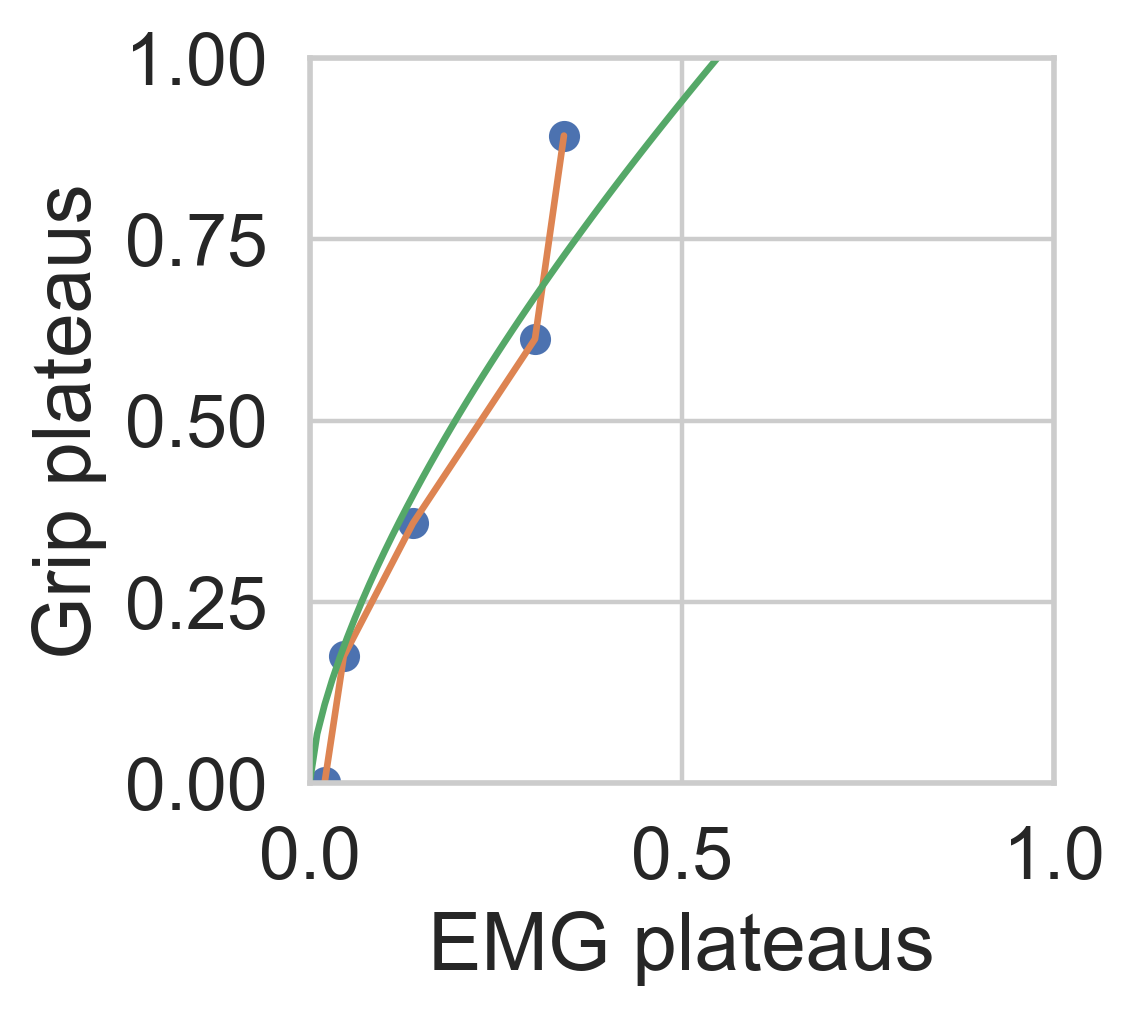

In [17]:
#### Static Koopman operator with gradient boosting for mapping processed EMG signal to Grip signal

# Specify downsampling step
dat_step = 8
# Basin hopping Bounds for plateau cutoff, shrinking factor, delay*10^-3
bounds_bh=[(0.03, 0.15), (0.05, 0.9), (30e-2, 50e-2)]
x0_bh = [0.07, 0.3, 40e-2]
# Basin-hopping stepsize
stepsize_bh = 0.1
# Number of iterations for basin-hopping
niter_bh = 10
# Create new dictionary for data processed in batches and downsampled
# Copy keys from dictionary proc_data and instantiate empty lists
proc_data_blk = {key: [] for key in proc_data.keys()} 
del proc_data_blk['corrs']
proc_data_blk['emg_processed_transformed'] = []
proc_data_blk['grip_approx'] = []
proc_data_blk['max_corr'] = []
proc_data_blk['max_corr_lag'] = []
proc_data_blk['zero_cutoff'] = []
proc_data_blk['shrinking_factor'] = []
proc_data_blk['time_delay'] = []
proc_data_blk['rmse'] = []
proc_data_blk['mae'] = []
proc_data_blk['mae_mvc'] = []
proc_data_blk['wmape'] = []
for i in range(3):
    proc_data_blk[f'rest_cutoff_{i}'] = []
for i in range(5):
    proc_data_blk[f'plateau_emg_{i}'] = []
    proc_data_blk[f'plateau_grip_{i}'] = []
# Iterate over all keys, and obtain approximations and parameters
# for id_ind in range(len(proc_data['time_t'])):
# for id_ind in [25]:
for id_ind in [4]:
    # Load data for specific patient, measurement and position
    file_name = proc_data['file_names'][id_ind]
    proc_data_blk['file_names'].append(file_name)
    print(f'File number: name: {id_ind}: {file_name}')
    time_t = proc_data['time_t'][id_ind]
    emg = proc_data['emg'][id_ind]
    emg_proc = proc_data['emg_processed'][id_ind]
    grip = proc_data['grip'][id_ind]
    corrs = proc_data['corrs'][id_ind]
    proc_data_blk['max_corr'].append(np.max(corrs))
    lags = scipy.signal.correlation_lags(len(emg_proc), len(grip))
    proc_data_blk['max_corr_lag'].append(lags[np.argmax(corrs)])

    # Remove local optimization and correct step is each decision vector direction
    bounds_minimizer = BoundsNoLocalMinimization(
        bounds=bounds_bh
        )
    take_step = TakeStepRutine(
        bounds=bounds_bh,
        stepsize=stepsize_bh
        )

    # Get optimal parameters for static Koopman operator
    static_koopman_opt = basinhopping(
        func=static_koopman_wmape,
        # Plateau cutoff, shrinking factor, delay*10^-3
        x0=x0_bh,
        niter=niter_bh,
        T=0.15,
        stepwise_factor=0.6, # 90% stepsize adjustment - tuned
        target_accept_rate=0.60, # 60% acceptance rate on step taking - tuned
        take_step=take_step,
        callback=bounds_minimizer.store_jumps,
        # accept_test=bounds_minimizer.impose_bounds,
        minimizer_kwargs={
            'method': bounds_minimizer.no_minimization, 
            'args': (emg_proc, grip, dat_step),
            },
        )

    # Store optimal parameters
    proc_data_blk['zero_cutoff'].append(static_koopman_opt.x[0])
    proc_data_blk['shrinking_factor'].append(static_koopman_opt.x[1])
    proc_data_blk['time_delay'].append(round(static_koopman_opt.x[2]*1e2))
    # Run optimization function once to store results in global object static_koopman_gb
    static_koopman_wmape(static_koopman_opt.x, emg_proc, grip, dat_step)

    # Approximate entire dataset in bulks of 496 samples - simulating real-time
    grip_blk_approx_full = []
    grip_blk_full = []
    time_t_blk_full = []
    emg_blk_full = []
    emg_proc_blk_full = []
    emg_proc_trans_blk_full = []
    for time_blk, emg_blk, emg_proc_blk, grp_blk in np.nditer(
        [time_t, emg, emg_proc, grip],
        flags=['external_loop', 'buffered'], buffersize=496
        ):
        if emg_blk.size < 496 or grp_blk.size < 496:
            continue
        # Append downsampled time and original emg
        time_t_blk_full.append(time_blk[::dat_step])
        emg_blk_full.append(emg_blk[::dat_step])
        # Downsample EMG signal
        emg_proc_blk_full.append(emg_proc_blk[::dat_step])
        # Append downsampled grip
        grip_blk_full.append(grp_blk[::dat_step])
        emg_proc_trans_blk_full.append(
            static_koopman_gb.transformer_emg.transform(emg_proc_blk_full[-1].reshape(-1, 1)).ravel()
            )
        grip_blk_approx_full.append(static_koopman_gb.koopman_operator @ blocked_hankel_lift(
            observables=emg_proc_trans_blk_full[-1].reshape(1, -1), 
            num_delays=round(static_koopman_opt.x[2]*1e2)
            ))
        grip_blk_approx_full[-1] = np.hstack(
            (grip_blk_approx_full[-1][0, :], grip_blk_approx_full[-1][1:, -1])
            ).real
        # Threshold too low values to -1 N if below
        grip_blk_approx_full[-1][grip_blk_approx_full[-1] < -1] = -1
    time_t_blk_full = np.hstack(time_t_blk_full)
    emg_blk_full = np.hstack(emg_blk_full)
    emg_proc_blk_full = np.hstack(emg_proc_blk_full)
    emg_proc_trans_blk_full = np.hstack(emg_proc_trans_blk_full)
    grip_blk_full = np.hstack(grip_blk_full)
    grip_blk_approx_full = np.hstack(grip_blk_approx_full)

    proc_data_blk['time_t'].append(time_t_blk_full)
    proc_data_blk['emg'].append(emg_blk_full)
    proc_data_blk['emg_processed'].append(emg_proc_blk_full)
    proc_data_blk['emg_processed_transformed'].append(emg_proc_trans_blk_full)
    proc_data_blk['grip'].append(grip_blk_full)
    proc_data_blk['grip_approx'].append(grip_blk_approx_full)

    # Extract transformer from pipeline
    plateaus_transformer = static_koopman_gb.transformer_emg.named_steps['PlateauCompensator']
    rest_cutoffs = plateaus_transformer.rest_ind_cutoff
    # print(f'Rest cutoffs: {rest_cutoffs}')
    plateaus_emg = plateaus_transformer.plateaus_emg
    plateaus_grip = plateaus_transformer.plateaus_grip
    correction_func = plateaus_transformer.correct_func
    coeffs = plateaus_transformer.coeffs
    # Store rest cutoffs, plateaus and correction function coefficients
    for i, rst_cut in enumerate(rest_cutoffs):
        proc_data_blk[f'rest_cutoff_{i}'].append(rst_cut) 
    for i, plat_emg in enumerate(plateaus_emg):
        proc_data_blk[f'plateau_emg_{i}'].append(plat_emg)
    for i, plat_grip in enumerate(plateaus_grip):
        proc_data_blk[f'plateau_grip_{i}'].append(plat_grip)

    # Add error metrics to proc_data_blk
    proc_data_blk['rmse'].append(np.sqrt(np.mean((grip_blk_full - grip_blk_approx_full)**2)))
    proc_data_blk['mae'].append(np.mean(np.abs(grip_blk_full - grip_blk_approx_full)))
    proc_data_blk['mae_mvc'].append(np.mean(np.abs(grip_blk_full - grip_blk_approx_full)) / grip_blk_full.max() * 100)
    proc_data_blk['wmape'].append(np.abs(grip_blk_full - grip_blk_approx_full).sum() / np.abs(grip_blk_full).sum() * 100)
    

    print(f'RMSE: {proc_data_blk["rmse"][-1]}')
    print(f'MAE: {proc_data_blk["mae"][-1]}')
    print(f'MAE as %MVC: {proc_data_blk["mae_mvc"][-1]} %')
    print(f'wMAPE: {proc_data_blk["wmape"][-1]} %')

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3, 3), dpi=320)
    # Plot approximations
    # ax[0].plot(grip_blk_full)
    # ax[0].plot(grip_blk_approx_full)
    # ax[0].plot(emg_proc_trans_blk_full)
    # Plot rest cutoffs
    # TODO: indices approximately align since downsampling was performed differently for
    # batch processing and complete processing
    # for rst_cut in rest_cutoffs:
    #     ax[0].axvline(rst_cut, color='r', linestyle='--')
    # Plot plateaus one vs another
    ax.plot(plateaus_emg, plateaus_grip, 'o')
    ax.plot(plateaus_emg, plateaus_grip)
    ax.set_xlabel('EMG plateaus')
    ax.set_ylabel('Grip plateaus')
    ax.plot(np.linspace(0, 1, 100), correction_func(np.linspace(0, 1, 100)))
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])

In [356]:
proc_data_blk

{'file_names': ['dsp3m1_22_m'],
 'time_t': [array([1.71809847e+09, 1.71809847e+09, 1.71809847e+09, ...,
         1.71809851e+09, 1.71809851e+09, 1.71809851e+09])],
 'emg': [array([-1.60385919, -2.01812577, -1.58782423, ..., -1.63479948,
         -1.62628913, -1.63965559])],
 'emg_processed': [array([0.4558616 , 0.45552917, 0.46079301, ..., 0.06493291, 0.06451948,
         0.06232764])],
 'grip': [array([238.25573865, 237.96733638, 237.67893411, ...,   4.3722027 ,
           4.07440539,   3.80509063])],
 'emg_processed_transformed': [array([218.27517109, 218.16216799, 219.94834475, ...,  49.00242529,
          48.72420818,  47.23686997])],
 'grip_approx': [array([234.09357489, 235.35143235, 235.19016788, ...,  46.45185635,
          45.92482659,  45.41848023])],
 'max_corr': [0.8907436582179763],
 'max_corr_lag': [125],
 'zero_cutoff': [0.05716130283173952],
 'shrinking_factor': [0.502467783376865],
 'time_delay': [41],
 'rmse': [25.980717483060563],
 'mae': [18.401907913539237],
 'mae_

In [80]:
# Create a dataframe and export proc_data to csv
proc_data_df = pd.DataFrame({k: v for k, v in proc_data_blk.items()})
proc_data_df
tot_len = 0
for i in proc_data_df['time_t']:
    tot_len += len(i)
print(f'Total length: {tot_len}')
proc_data_df = proc_data_df.explode(
    ['time_t', 'emg', 'emg_processed', 'emg_processed_transformed', 'grip', 'grip_approx']
    )
proc_data_df
proc_data_df.to_csv('data/processed_approximated_data_dwns8_pos3.csv', index=False)

Total length: 84320


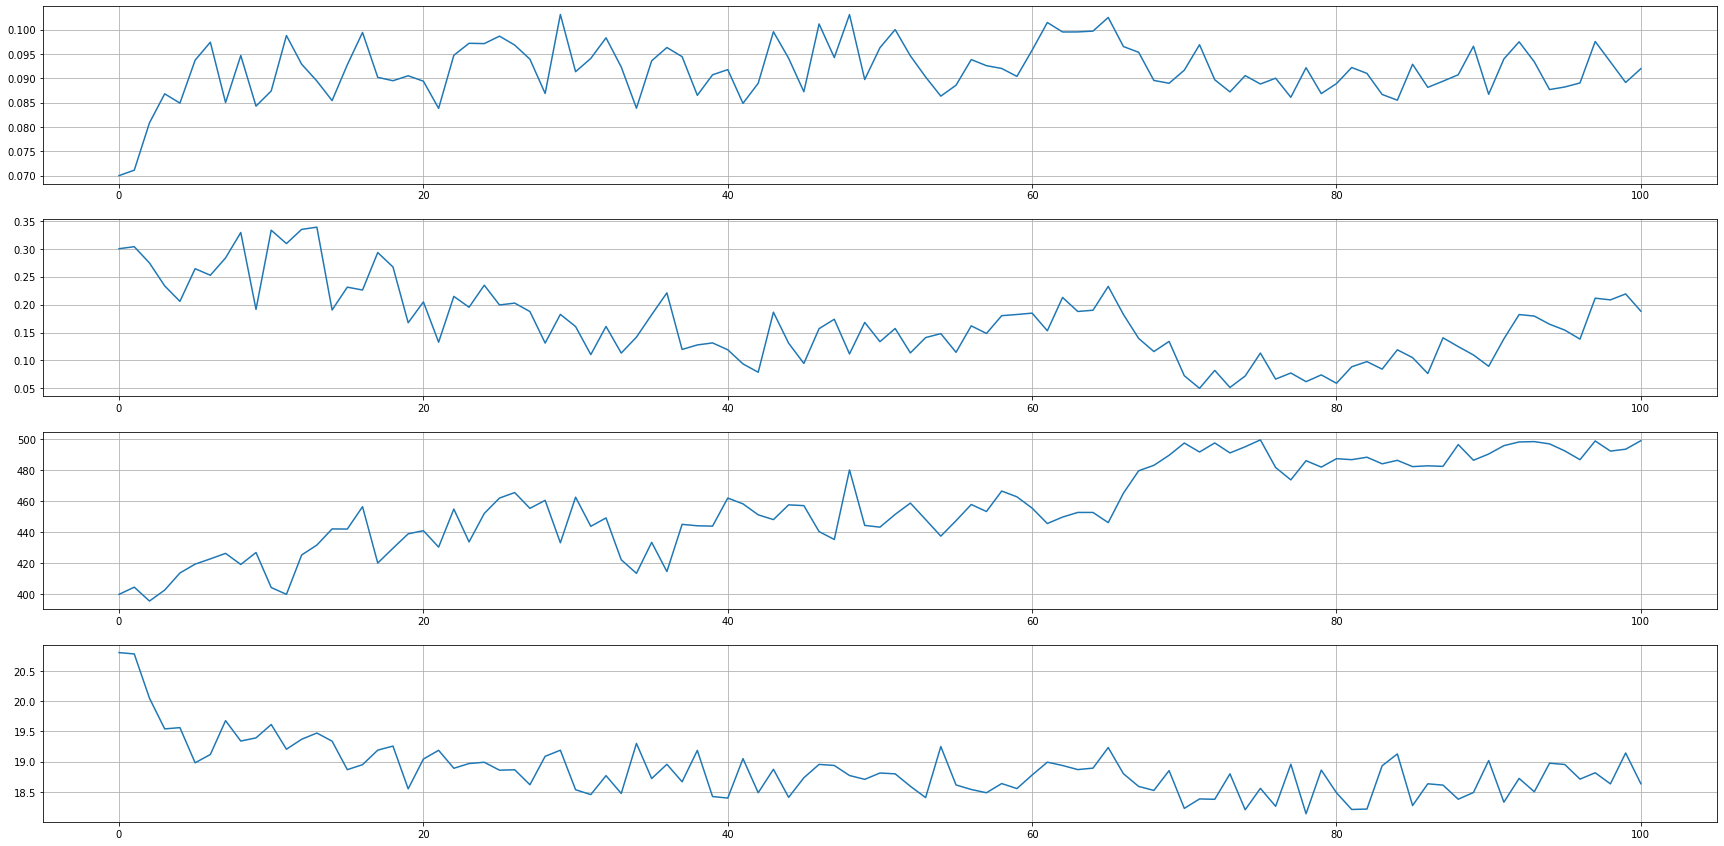

In [253]:
plateau_cutoff = [i[0] for i in bounds_minimizer.x]
shrinking_factor = [i[1] for i in bounds_minimizer.x]
delay = [i[2]*1e3 for i in bounds_minimizer.x]
wmape = bounds_minimizer.f
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(30, 15))
ax[0].plot(plateau_cutoff, label='Plateau cutoff')
ax[1].plot(shrinking_factor, label='Shrinking factor')
ax[2].plot(delay, label='Delay')
ax[3].plot(wmape, label='wMAPE')

In [164]:
# Create a dataframe and export proc_data to csv
proc_data_df = pd.DataFrame({k: v for k, v in proc_data.items() if k != 'corrs'})
# proc_data_df.head()
# len(proc_data_df['time_t'][4])
proc_data_df = proc_data_df.explode(['time_t', 'emg', 'emg_processed', 'grip'])
proc_data_df.to_csv('data/processed_data_pos4.csv', index=False)

### Grip data prediction + estimation

In [828]:
a = np.arange(20).reshape(4, 5)
# Multiply all pairwise combinations of rows
display(a)
display(math.comb(a.shape[0], 2))
# Preallocate b for storing interactions between time delays
b = np.empty((a.shape[0] + math.comb(a.shape[0], 2), a.shape[1]))
# Store a at the end of b
b[-a.shape[0]:, :] = a
display(b)
for i, (mul1, mul2) in enumerate(itertools.combinations(a, 2)):
    # Populate rows in b with pairwise multiplication
    b[i, :] = mul1 * mul2
    print(i)
    print(mul1)
    print(mul2)

array([[ 0,  1,  2,  3,  4],
       [ 5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14],
       [15, 16, 17, 18, 19]])

6

array([[3.063e-322, 6.126e-322, 9.190e-322, 1.225e-321, 1.532e-321],
       [1.838e-321, 2.144e-321, 2.451e-321, 2.757e-321, 3.063e-321],
       [3.370e-321, 3.676e-321, 3.982e-321, 4.288e-321, 4.595e-321],
       [4.901e-321, 5.207e-321, 5.514e-321, 5.820e-321, 6.126e-321],
       [6.433e-321, 6.739e-321, 7.045e-321, 7.352e-321, 7.658e-321],
       [7.964e-321, 8.271e-321, 8.577e-321, 8.883e-321, 9.190e-321],
       [0.000e+000, 1.000e+000, 2.000e+000, 3.000e+000, 4.000e+000],
       [5.000e+000, 6.000e+000, 7.000e+000, 8.000e+000, 9.000e+000],
       [1.000e+001, 1.100e+001, 1.200e+001, 1.300e+001, 1.400e+001],
       [1.500e+001, 1.600e+001, 1.700e+001, 1.800e+001, 1.900e+001]])

0
[0 1 2 3 4]
[5 6 7 8 9]
1
[0 1 2 3 4]
[10 11 12 13 14]
2
[0 1 2 3 4]
[15 16 17 18 19]
3
[5 6 7 8 9]
[10 11 12 13 14]
4
[5 6 7 8 9]
[15 16 17 18 19]
5
[10 11 12 13 14]
[15 16 17 18 19]


array([[  0.,   6.,  14.,  24.,  36.],
       [  0.,  11.,  24.,  39.,  56.],
       [  0.,  16.,  34.,  54.,  76.],
       [ 50.,  66.,  84., 104., 126.],
       [ 75.,  96., 119., 144., 171.],
       [150., 176., 204., 234., 266.],
       [  0.,   1.,   2.,   3.,   4.],
       [  5.,   6.,   7.,   8.,   9.],
       [ 10.,  11.,  12.,  13.,  14.],
       [ 15.,  16.,  17.,  18.,  19.]])

In [977]:
##### Functions for predicting data
def predict_grip_pykmd(
    grip_approx: np.ndarray, num_delays: int, predict_horizon: int, 
    thinning_step: int = 1, threshold: list = [-10, 600], force_rank: int = 2
    ) -> np.ndarray:
    """
    Predict grip force using PyKMD library
    """
    # Add transformations
    grip_approx_obs = np.vstack((
        grip_approx,
        ))
    # Number of observables
    obs_num = grip_approx_obs.shape[0]
    # Add time delays on observables
    grip_approx_lift = block_hankel_lift(
        grip_approx_obs, delay=num_delays, thin_hankel=thinning_step
        )
    # Add interactions between all time delays
    # Preallocate grip_approx_lift_td_interact for storing interactions between time delays
    grip_approx_lift_td_interact = np.empty((
        grip_approx_lift.shape[0] + math.comb(grip_approx_lift.shape[0], 2),
        grip_approx_lift.shape[1]
         ))
    # Store grip_approx_lift at the end of grip_approx_lift_td_interact
    grip_approx_lift_td_interact[-grip_approx_lift.shape[0]:, :] = grip_approx_lift
    for i, (mul1, mul2) in enumerate(itertools.combinations(grip_approx_lift, 2)):
        # Populate rows in b with pairwise multiplication
        grip_approx_lift_td_interact[i, :] = np.log(mul1+10) * np.log(mul2+10)
    
    model = StreamingKmdModel(observables=grip_approx_lift_td_interact)
    model.initial_hankel_lifting(hankel_delays=0)
    model.initial_qr_compress()
    # print(f'Lifted observables shape: {model.lifted_observables.shape}')

    # Perform QR-DMD
    model.compute_model(
    procedure=Procedure.RRR,
    scaling_type=Scaling.COLUMNS, 
    centering_type=None,
    # balancing=Balancing.BALANCE,
    refine_ritz=RefineRitz.MINIMIZE_RESIDUALS(100),
    rank_mode=RankMode.FORCE(force_rank),
    # rank_mode=RankMode.THRESH_NONZERO_FIRST,
    )
    # Print rank
    # print(f'Rank: {model.ritz_values_lmbl.shape[0]}')

    # Compute coefficients/amplitudes using all snapshots
    eps = np.finfo(float).eps
    model.solve_coeffs_alpha(
    #TODO: maybe necessary to use tolerance_level=1 for QR solver
    # tolerance_level=1,
    # tolerance_level=1/eps,
    tolerance_level=4e10,
    observable_weights_scheme=WeightsScheme.UNIFORM,
    )

    # Extract row from predictions on lifted observables corresponding to last time delay
    predictions = model.predict_lifted(predict_horizon=predict_horizon).real[-obs_num, :]
    # Threshold too low values to minimal grip_approx and too high values to maximum grip_approx
    predictions[predictions < threshold[0]] = threshold[0]
    predictions[predictions > threshold[1]] = threshold[1]

    return predictions.ravel()

File name: ssp3m2_23_m
Number of batches: 47
Time to process all batches: 0.7087385654449463 s
wMAPE estimation: 4.332764558753657 %
wMAPE prediction: 10.773012807250064 %
Signal length: 23507
Max correlation: 0.9707262200235639
Correlation lag: 0
Correlation lag [ms]: 0.0


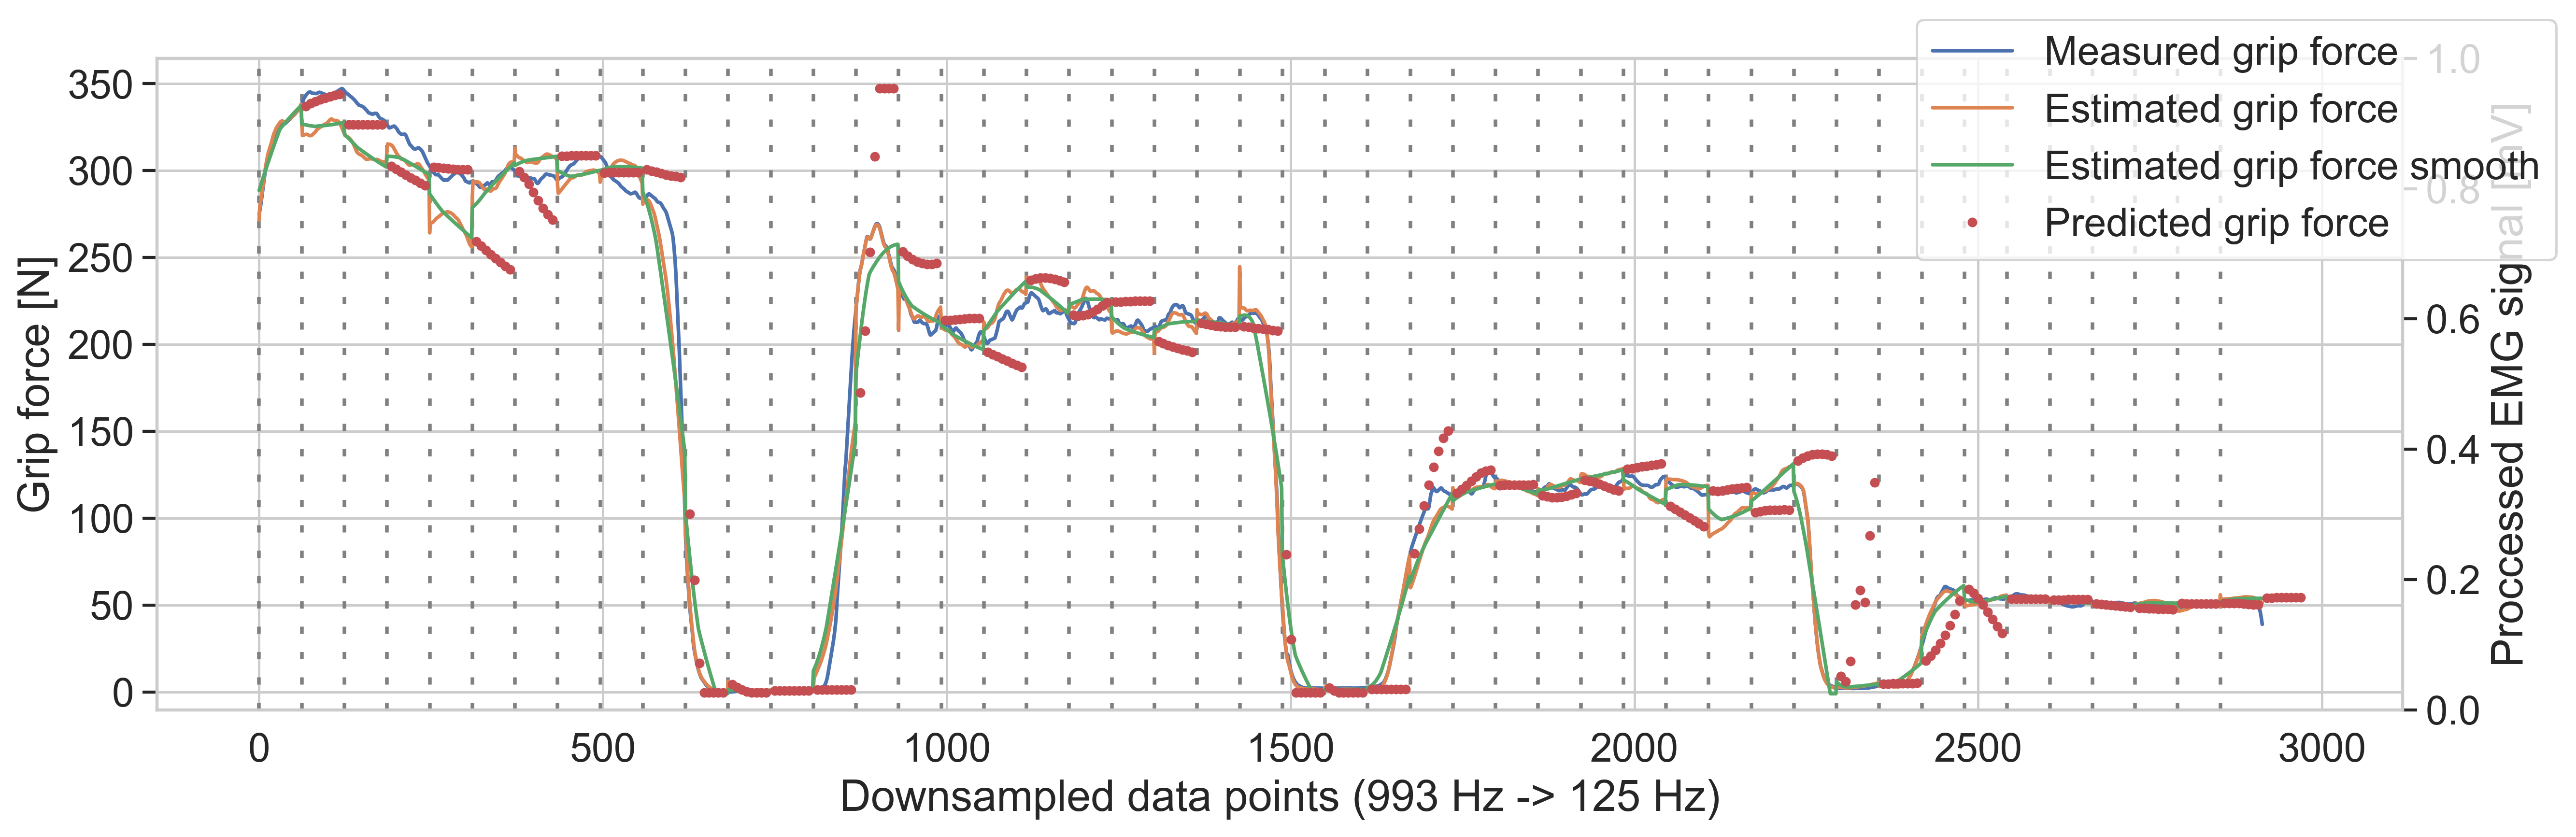

In [1184]:
# Specify downsampling step
dat_step = 8
# Number of time delays
num_delays = 60
num_delays_predict = 9
# Prediction downsampling
thin_step = 7
# Batch size as parameter
batch_size = 496//dat_step
predict_horizon = batch_size // thin_step
# Baatch modifiying coefficients for smoothing window size and prediction window size
batch_wnd_coeff = 1.8
batch_smooth_coeff = 1.4
# Force ran to keep number of modes
force_rank = 7
# Selection of time delays for grid observables
grid_td_select = [1, num_delays//2, num_delays]
# Slice_to_train Koopman
# slice_train = np.s_[750:3000]
# slice_train = np.s_[:2000]
slice_train = np.s_[:]
id_ind = 25
# id_ind = 2
# id_ind = 4
# id_ind = 15
# id_ind = 16
time_t = proc_data['time_t'][id_ind]
emg = proc_data['emg'][id_ind]
emg_proc = proc_data['emg_processed'][id_ind]
grip = proc_data['grip'][id_ind]
corrs = proc_data['corrs'][id_ind]
lags = scipy.signal.correlation_lags(len(emg_proc), len(grip))
print(f'File name: {proc_data["file_names"][id_ind]}')

transformer_emg = Pipeline([
    ('ZeroOneScaler', MinMaxScaler(feature_range=(0, 1)))
    ])
transformer_grip = Pipeline([
    ('ZeroOneScaler', MinMaxScaler(feature_range=(grip[::dat_step].min(), grip[::dat_step].max())))
    ])

emg_proc_scaled = transformer_emg.fit_transform(
    emg_proc[::dat_step][slice_train].reshape(-1, 1), grip[::dat_step][slice_train].reshape(-1, 1)
    ).ravel()
grip_trans = transformer_grip.fit_transform(grip[::dat_step][slice_train].reshape(-1, 1)).ravel()

grid_div = np.linspace(0, 1, 22)**1.8
emg_td_embed = blocked_hankel_lift(
    observables=emg_proc_scaled.reshape(1, -1), num_delays=num_delays
    )
# Use only 2 - 3 state/time delays since number of combinations explodes
grid_obs, grid_obs_ind = construct_grid_obs(emg_td_embed[grid_td_select, :], grid_div)

grip_emg_lift = StaticKoopmanInput(
    observables=np.vstack((
            emg_td_embed,
            grid_obs
            )),
    lin_trans=np.vstack((
        blocked_hankel_lift(grip_trans.reshape(1, -1), num_delays),
        np.zeros_like(grid_obs),
        )),
    )
koopman_operator = grip_emg_lift.lin_trans @ scipy.linalg.pinv(
    grip_emg_lift.observables
    )

# Compute grip approximation on bulk data
emg_proc_blk_stl = []
emg_proc_blk = []
grip_blk_orig = []
grip_blk_approx = []
grip_blk_approx_smooth = []
grip_blk_approx_predict = []
# Time just the batch processing
batch_proc_start = time.time()
for em_blk, grp_blk in np.nditer([emg_proc, grip], flags=['external_loop', 'buffered'], buffersize=496):
    if em_blk.size < 496 or grp_blk.size < 496:
        continue
    # Downsample EMG signal
    em_blk_dwns = em_blk[::dat_step]
    # Append downsampled grip
    grip_blk_orig.append(transformer_grip.transform(grp_blk[::dat_step].reshape(-1, 1)).ravel())
    emg_blk_trans = transformer_emg.transform(em_blk_dwns.reshape(-1, 1)).ravel()
    emg_proc_blk.append(emg_blk_trans)

    emg_td_embed_blk = blocked_hankel_lift(emg_blk_trans.reshape(1, -1), num_delays=num_delays)
    # Constuct grid observables, but keep indices from learned model on entire dataset
    grid_obs, _ = construct_grid_obs(emg_td_embed_blk[grid_td_select, :], grid_div, keep_indices=grid_obs_ind)
    grip_blk_approx.append(koopman_operator @ np.vstack((
            emg_td_embed_blk,
            grid_obs
            )))
    grip_blk_approx[-1] = np.hstack((grip_blk_approx[-1][0, :], grip_blk_approx[-1][1:num_delays+1, -1])).real
    # Threshold too low values to -1 N if below
    grip_blk_approx[-1][grip_blk_approx[-1] < -1] = -1
    # Predict grip force from it's approximation
    # Stacked history - batch_smooth_coeff is always <= then 2, so last two batches will be enough
    grip_approx_hist = np.hstack(grip_blk_approx[-2:])
    # Smooth approximation
    # Fraction of data for smoothing
    if len(grip_approx_hist) > 1*batch_size:
        smooth_frac = (batch_size*batch_smooth_coeff)/len(grip_approx_hist)
    else:
        # Smooth using entire batch only for the first batch
        smooth_frac = 1
    # Smooth data using LOWESS
    lowess_smooth = sm.nonparametric.lowess(
        grip_approx_hist, range(len(grip_approx_hist)), 
        frac=smooth_frac, it=0,
        is_sorted=True, missing='none', return_sorted=False
        )
    grip_blk_approx_smooth.append(lowess_smooth[-batch_size:])
    # Threshold too low values to -1 N if below
    grip_blk_approx_smooth[-1][grip_blk_approx_smooth[-1] < -1] = -1
    grip_blk_approx_predict.append(
        predict_grip_pykmd(
            # Take batch size modified by batch_wnd_coeff for prediction
            grip_approx=np.hstack(grip_blk_approx_smooth[-2:])[-int(batch_size*batch_wnd_coeff):].reshape(1, -1),
            num_delays=num_delays_predict,
            predict_horizon=predict_horizon,
            thinning_step=thin_step,
            threshold=[grip[::dat_step].min(), grip[::dat_step].max()],
            force_rank=force_rank
            ))

batch_proc_duration = time.time() - batch_proc_start
num_batches = len(grip_blk_orig)
print(f'Number of batches: {num_batches}')
print(f'Time to process all batches: {batch_proc_duration} s')
grip_blk_orig = np.hstack(grip_blk_orig)
emg_proc_blk = np.hstack(emg_proc_blk)
grip_blk_approx = np.hstack(grip_blk_approx)
grip_blk_approx_smooth = np.hstack(grip_blk_approx_smooth)
grip_blk_approx_predict = np.hstack(grip_blk_approx_predict)

wmape_est = np.abs(grip_blk_orig - grip_blk_approx).sum() / np.abs(grip_blk_orig).sum() * 100

print(f'wMAPE estimation: {wmape_est} %')

plot_indices = np.arange(len(grip_blk_orig))
# Plot indices for predictions
plot_predict_indices = np.arange(1, num_batches+1) * batch_size - 1
# print(f'Predict indices: {plot_predict_indices}')
plot_predict_indices = (
    plot_predict_indices.reshape(-1, 1) + thin_step * np.arange(1, predict_horizon+1)
    ).ravel()
# print(f'Predict indices: {plot_predict_indices}')
# print(f'Predict indices shape: {plot_predict_indices.shape}')
wmape_pred = np.abs(
    grip_blk_orig[plot_predict_indices[plot_predict_indices <= plot_indices.max()]] -
    grip_blk_approx_predict[plot_predict_indices <= plot_indices.max()]).sum() / np.abs(
        grip_blk_orig[plot_predict_indices[plot_predict_indices <= plot_indices.max()]]).sum() * 100
print(f'wMAPE prediction: {wmape_pred} %')

plot_y_min = grip[::dat_step].min() - 10
plot_y_max = grip[::dat_step].max() * 1.05
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 5), dpi=360)
# Secondary axis for EMG data
ax2 = ax.twinx()
ax2.grid()
# Batch lines
ax.vlines(np.arange(0, len(grip_blk_orig), batch_size), plot_y_min, plot_y_max, color='grey', linestyle=(0, (2, 5)))
# ax.plot(time_t, emg_proc_scaled)
# ax.plot(emg_proc_scaled)
# ax2.plot(emg_proc_blk, color='g', label='Processed EMG signal')
# ax.plot(grip_trans)
ax.plot(plot_indices, grip_blk_orig, label='Measured grip force')
ax.plot(plot_indices, grip_blk_approx, label='Estimated grip force')
ax.plot(plot_indices, grip_blk_approx_smooth, label='Estimated grip force smooth')
# ax.plot(plot_predict_indices, grip_blk_approx_predict, label='Predicted grip force')
ax.plot(plot_predict_indices, grip_blk_approx_predict, '.', label='Predicted grip force')

ax.set_ylim([plot_y_min, plot_y_max])
ax.set_xlabel('Downsampled data points (993 Hz -> 125 Hz)')
ax.set_ylabel('Grip force [N]')
ax2.set_ylabel('Proccessed EMG signal [mV]')
fig.legend()
fig.tight_layout()

print(f'Signal length: {len(emg_proc)}')
print(f'Max correlation: {np.max(corrs)}')
print(f'Correlation lag: {lags[np.argmax(corrs)]}')
print(f'Correlation lag [ms]: {lags[np.argmax(corrs)] * 1 / 992.969696969697 * 1e3}')

In [1178]:
#### Grid search for optimal parameters for PyKMD prediction
# Specify downsampling step
dat_step = 8
# Number of time delays
num_delays = 60
# Batch size as parameter
batch_size = 496//dat_step
# Selection of time delays for grid observables
grid_td_select = [1, num_delays//2, num_delays]
# Slice_to_train Koopman
slice_train = np.s_[:]
id_ind = 25

# Load data
time_t = proc_data['time_t'][id_ind]
emg = proc_data['emg'][id_ind]
emg_proc = proc_data['emg_processed'][id_ind]
grip = proc_data['grip'][id_ind]
corrs = proc_data['corrs'][id_ind]
print(f'File name: {proc_data["file_names"][id_ind]}')


transformer_emg = Pipeline([
    ('ZeroOneScaler', MinMaxScaler(feature_range=(0, 1)))
    ])
transformer_grip = Pipeline([
    ('ZeroOneScaler', MinMaxScaler(feature_range=(grip[::dat_step].min(), grip[::dat_step].max())))
    ])

emg_proc_scaled = transformer_emg.fit_transform(
    emg_proc[::dat_step][slice_train].reshape(-1, 1), grip[::dat_step][slice_train].reshape(-1, 1)
    ).ravel()
grip_trans = transformer_grip.fit_transform(grip[::dat_step][slice_train].reshape(-1, 1)).ravel()

grid_div = np.linspace(0, 1, 22)**1.8
emg_td_embed = blocked_hankel_lift(
    observables=emg_proc_scaled.reshape(1, -1), num_delays=num_delays
    )
# Use only 2 - 3 state/time delays since number of combinations explodes
grid_obs, grid_obs_ind = construct_grid_obs(emg_td_embed[grid_td_select, :], grid_div)

grip_emg_lift = StaticKoopmanInput(
    observables=np.vstack((
            emg_td_embed,
            grid_obs
            )),
    lin_trans=np.vstack((
        blocked_hankel_lift(grip_trans.reshape(1, -1), num_delays),
        np.zeros_like(grid_obs),
        )),
    )
koopman_operator = grip_emg_lift.lin_trans @ scipy.linalg.pinv(
    grip_emg_lift.observables
    )

# Grid search on force_rank, thin_step and num_delays_predict
optim_results = {
    # Parameters - batch_wnd_coeff, batch_smooth_coeff, thin_step, predict_horizon, num_delays_predict, force_rank
    'params': [],
    'wmape_pred': []
}

for batch_wnd_coeff in np.linspace(1.3, 1.8, 6):
    # if batch_wnd_coeff != 1.3:
    #     continue
    print(f'Batch window coefficient: {batch_wnd_coeff}')
    for batch_smooth_coeff in np.linspace(1.4, 1.9, 6):
        # if batch_smooth_coeff != 1.5:
        #     continue
        for thin_step in range(3, 9):
            # if thin_step != 7:
            #     continue
            # print(f'Thin step: {thin_step}')
            predict_horizon = batch_size // thin_step
            for num_delays_predict in range(4, 10):
                # if num_delays_predict != 4:
                #     continue
                for force_rank in range(3, num_delays_predict+1):
                    # if force_rank != 4:
                    #     continue
                    # Limit force_rank to 7
                    if force_rank > 7:
                        continue
                    # print(f'Rank: {force_rank}')
            
                    # Compute grip approximation and prediction on bulk data
                    grip_blk_orig = []
                    grip_blk_approx = []
                    grip_blk_approx_smooth = []
                    grip_blk_approx_predict = []
                    try:
                        for em_blk, grp_blk in np.nditer([emg_proc, grip], flags=['external_loop', 'buffered'], buffersize=496):
                            if em_blk.size < 496 or grp_blk.size < 496:
                                continue
                            # Downsample EMG signal
                            em_blk_dwns = em_blk[::dat_step]
                            # Append downsampled grip
                            grip_blk_orig.append(transformer_grip.transform(grp_blk[::dat_step].reshape(-1, 1)).ravel())
                            emg_blk_trans = transformer_emg.transform(em_blk_dwns.reshape(-1, 1)).ravel()

                            emg_td_embed_blk = blocked_hankel_lift(emg_blk_trans.reshape(1, -1), num_delays=num_delays)
                            # Constuct grid observables, but keep indices from learned model on entire dataset
                            grid_obs, _ = construct_grid_obs(emg_td_embed_blk[grid_td_select, :], grid_div, keep_indices=grid_obs_ind)
                            grip_blk_approx.append(koopman_operator @ np.vstack((
                                    emg_td_embed_blk,
                                    grid_obs
                                    )))
                            grip_blk_approx[-1] = np.hstack((grip_blk_approx[-1][0, :], grip_blk_approx[-1][1:num_delays+1, -1])).real
                            # Threshold too low values to -1 N if below
                            grip_blk_approx[-1][grip_blk_approx[-1] < -1] = -1
                            # Stacked history - batch_smooth_coeff is always <= then 2, so last two batches will be enough
                            grip_approx_hist = np.hstack(grip_blk_approx[-2:])
                            # Smooth approximation
                            # Fraction of data for smoothing
                            if len(grip_approx_hist) > 1*batch_size:
                                smooth_frac = (batch_size*batch_smooth_coeff)/len(grip_approx_hist)
                            else:
                                # Smooth using entire batch only for the first batch
                                smooth_frac = 1
                            # Smooth data using LOWESS
                            lowess_smooth = sm.nonparametric.lowess(
                                grip_approx_hist, range(len(grip_approx_hist)), 
                                frac=smooth_frac, it=0,
                                is_sorted=True, missing='none', return_sorted=False
                                )
                            # Append only last batch size to smoothed data
                            grip_blk_approx_smooth.append(lowess_smooth[-batch_size:])
                            # Threshold too low values to -1 N if below
                            grip_blk_approx_smooth[-1][grip_blk_approx_smooth[-1] < -1] = -1
                            grip_blk_approx_predict.append(
                                predict_grip_pykmd(
                                    # Take batch size modified by batch_wnd_coeff for prediction
                                    grip_approx=np.hstack(grip_blk_approx_smooth[-2:])[-int(batch_size*batch_wnd_coeff):].reshape(1, -1),
                                    num_delays=num_delays_predict,
                                    predict_horizon=predict_horizon,
                                    thinning_step=thin_step,
                                    # Threshold for predictions, min and max from initial experiment
                                    threshold=[grip[::dat_step].min(), grip[::dat_step].max()],
                                    force_rank=force_rank
                                    ))
                    except ValueError as e:
                        # Print parameters
                        # print(f"Bad params: {optim_results['params'][-1]}")
                        # Print error
                        # print(e)
                        continue
                            
                    num_batches = len(grip_blk_orig)
                    grip_blk_orig = np.hstack(grip_blk_orig)
                    grip_blk_approx_predict = np.hstack(grip_blk_approx_predict)

                    plot_indices = np.arange(len(grip_blk_orig))
                    # Plot indices for predictions
                    plot_predict_indices = np.arange(1, num_batches+1) * batch_size - 1
                    plot_predict_indices = (
                        plot_predict_indices.reshape(-1, 1) + thin_step * np.arange(1, predict_horizon+1)
                        ).ravel()
                    wmape_pred = np.abs(
                        grip_blk_orig[plot_predict_indices[plot_predict_indices <= plot_indices.max()]] -
                        grip_blk_approx_predict[plot_predict_indices <= plot_indices.max()]).sum() / np.abs(
                            grip_blk_orig[plot_predict_indices[plot_predict_indices <= plot_indices.max()]]).sum() * 100
                    # Store wmape prediction
                    optim_results['params'].append((
                        batch_wnd_coeff, batch_smooth_coeff, thin_step, predict_horizon,
                        num_delays_predict, force_rank
                        ))
                    optim_results['wmape_pred'].append(wmape_pred)

File name: ssp3m2_23_m
Batch window coefficient: 1.3


ERROR:root:Mode to determine numerical rank not properly set!
ERROR:root:Mode to determine numerical rank not properly set!
ERROR:root:Mode to determine numerical rank not properly set!
ERROR:root:Mode to determine numerical rank not properly set!
ERROR:root:Mode to determine numerical rank not properly set!
ERROR:root:Mode to determine numerical rank not properly set!
ERROR:root:Mode to determine numerical rank not properly set!
ERROR:root:Mode to determine numerical rank not properly set!
ERROR:root:Mode to determine numerical rank not properly set!
ERROR:root:Mode to determine numerical rank not properly set!
ERROR:root:Mode to determine numerical rank not properly set!
ERROR:root:Mode to determine numerical rank not properly set!
/home/tomislav/git/koopman-toolkit/src/pykmd/src/pykmd/libs/solve.py:161: LinAlgWarning: Ill-conditioned matrix (rcond=2.0896e-18): result may not be accurate.
  coeffs_alpha: NDArrayFloatComplex = scipy.linalg.solve(
/home/tomislav/git/koopman-toolkit/src

Batch window coefficient: 1.4000000000000001


ERROR:root:Mode to determine numerical rank not properly set!
ERROR:root:Mode to determine numerical rank not properly set!
ERROR:root:Mode to determine numerical rank not properly set!
ERROR:root:Mode to determine numerical rank not properly set!
ERROR:root:Mode to determine numerical rank not properly set!
ERROR:root:Mode to determine numerical rank not properly set!
ERROR:root:Mode to determine numerical rank not properly set!
ERROR:root:Mode to determine numerical rank not properly set!
ERROR:root:Mode to determine numerical rank not properly set!
/home/tomislav/git/koopman-toolkit/src/pykmd/src/pykmd/libs/solve.py:161: LinAlgWarning: Ill-conditioned matrix (rcond=7.49232e-17): result may not be accurate.
  coeffs_alpha: NDArrayFloatComplex = scipy.linalg.solve(
ERROR:root:Mode to determine numerical rank not properly set!
ERROR:root:Mode to determine numerical rank not properly set!
ERROR:root:Mode to determine numerical rank not properly set!
/home/tomislav/git/koopman-toolkit/sr

Batch window coefficient: 1.5


ERROR:root:Mode to determine numerical rank not properly set!
ERROR:root:Mode to determine numerical rank not properly set!
ERROR:root:Mode to determine numerical rank not properly set!
ERROR:root:Mode to determine numerical rank not properly set!
ERROR:root:Mode to determine numerical rank not properly set!
ERROR:root:Mode to determine numerical rank not properly set!
ERROR:root:Mode to determine numerical rank not properly set!
ERROR:root:Mode to determine numerical rank not properly set!
ERROR:root:Mode to determine numerical rank not properly set!
/home/tomislav/git/koopman-toolkit/src/pykmd/src/pykmd/libs/solve.py:161: LinAlgWarning: Ill-conditioned matrix (rcond=1.49767e-17): result may not be accurate.
  coeffs_alpha: NDArrayFloatComplex = scipy.linalg.solve(
/home/tomislav/git/koopman-toolkit/src/pykmd/src/pykmd/libs/solve.py:161: LinAlgWarning: Ill-conditioned matrix (rcond=1.05886e-18): result may not be accurate.
  coeffs_alpha: NDArrayFloatComplex = scipy.linalg.solve(
ERRO

Batch window coefficient: 1.6


ERROR:root:Mode to determine numerical rank not properly set!
ERROR:root:Mode to determine numerical rank not properly set!
ERROR:root:Mode to determine numerical rank not properly set!
ERROR:root:Mode to determine numerical rank not properly set!
ERROR:root:Mode to determine numerical rank not properly set!
ERROR:root:Mode to determine numerical rank not properly set!
ERROR:root:Mode to determine numerical rank not properly set!
ERROR:root:Mode to determine numerical rank not properly set!
ERROR:root:Mode to determine numerical rank not properly set!
/home/tomislav/git/koopman-toolkit/src/pykmd/src/pykmd/libs/solve.py:161: LinAlgWarning: Ill-conditioned matrix (rcond=1.49767e-17): result may not be accurate.
  coeffs_alpha: NDArrayFloatComplex = scipy.linalg.solve(
/home/tomislav/git/koopman-toolkit/src/pykmd/src/pykmd/libs/solve.py:161: LinAlgWarning: Ill-conditioned matrix (rcond=5.34112e-20): result may not be accurate.
  coeffs_alpha: NDArrayFloatComplex = scipy.linalg.solve(
ERRO

Batch window coefficient: 1.7000000000000002


ERROR:root:Mode to determine numerical rank not properly set!
ERROR:root:Mode to determine numerical rank not properly set!
ERROR:root:Mode to determine numerical rank not properly set!
ERROR:root:Mode to determine numerical rank not properly set!
ERROR:root:Mode to determine numerical rank not properly set!
ERROR:root:Mode to determine numerical rank not properly set!
ERROR:root:Mode to determine numerical rank not properly set!
ERROR:root:Mode to determine numerical rank not properly set!
ERROR:root:Mode to determine numerical rank not properly set!
/home/tomislav/git/koopman-toolkit/src/pykmd/src/pykmd/libs/solve.py:161: LinAlgWarning: Ill-conditioned matrix (rcond=1.3781e-19): result may not be accurate.
  coeffs_alpha: NDArrayFloatComplex = scipy.linalg.solve(
/home/tomislav/git/koopman-toolkit/src/pykmd/src/pykmd/libs/solve.py:161: LinAlgWarning: Ill-conditioned matrix (rcond=1.57845e-20): result may not be accurate.
  coeffs_alpha: NDArrayFloatComplex = scipy.linalg.solve(
ERROR

Batch window coefficient: 1.8


ERROR:root:Mode to determine numerical rank not properly set!
ERROR:root:Mode to determine numerical rank not properly set!
ERROR:root:Mode to determine numerical rank not properly set!
ERROR:root:Mode to determine numerical rank not properly set!
ERROR:root:Mode to determine numerical rank not properly set!
ERROR:root:Mode to determine numerical rank not properly set!
ERROR:root:Mode to determine numerical rank not properly set!
ERROR:root:Mode to determine numerical rank not properly set!
ERROR:root:Mode to determine numerical rank not properly set!
/home/tomislav/git/koopman-toolkit/src/pykmd/src/pykmd/libs/solve.py:161: LinAlgWarning: Ill-conditioned matrix (rcond=7.01495e-19): result may not be accurate.
  coeffs_alpha: NDArrayFloatComplex = scipy.linalg.solve(
/home/tomislav/git/koopman-toolkit/src/pykmd/src/pykmd/libs/solve.py:161: LinAlgWarning: Ill-conditioned matrix (rcond=1.33484e-21): result may not be accurate.
  coeffs_alpha: NDArrayFloatComplex = scipy.linalg.solve(
ERRO

In [1179]:
# Get optimal parameters for minimal wmape prediction
# Parameters - batch_wnd_coeff, batch_smooth_coeff, thin_step, predict_horizon, num_delays_predict, force_rank
optim_results['params'][np.argmin(optim_results['wmape_pred'])]
# len(optim_results['params'])

(1.8, 1.4, 7, 8, 9, 7)

In [1156]:
7*8*6*6*3/60

100.8

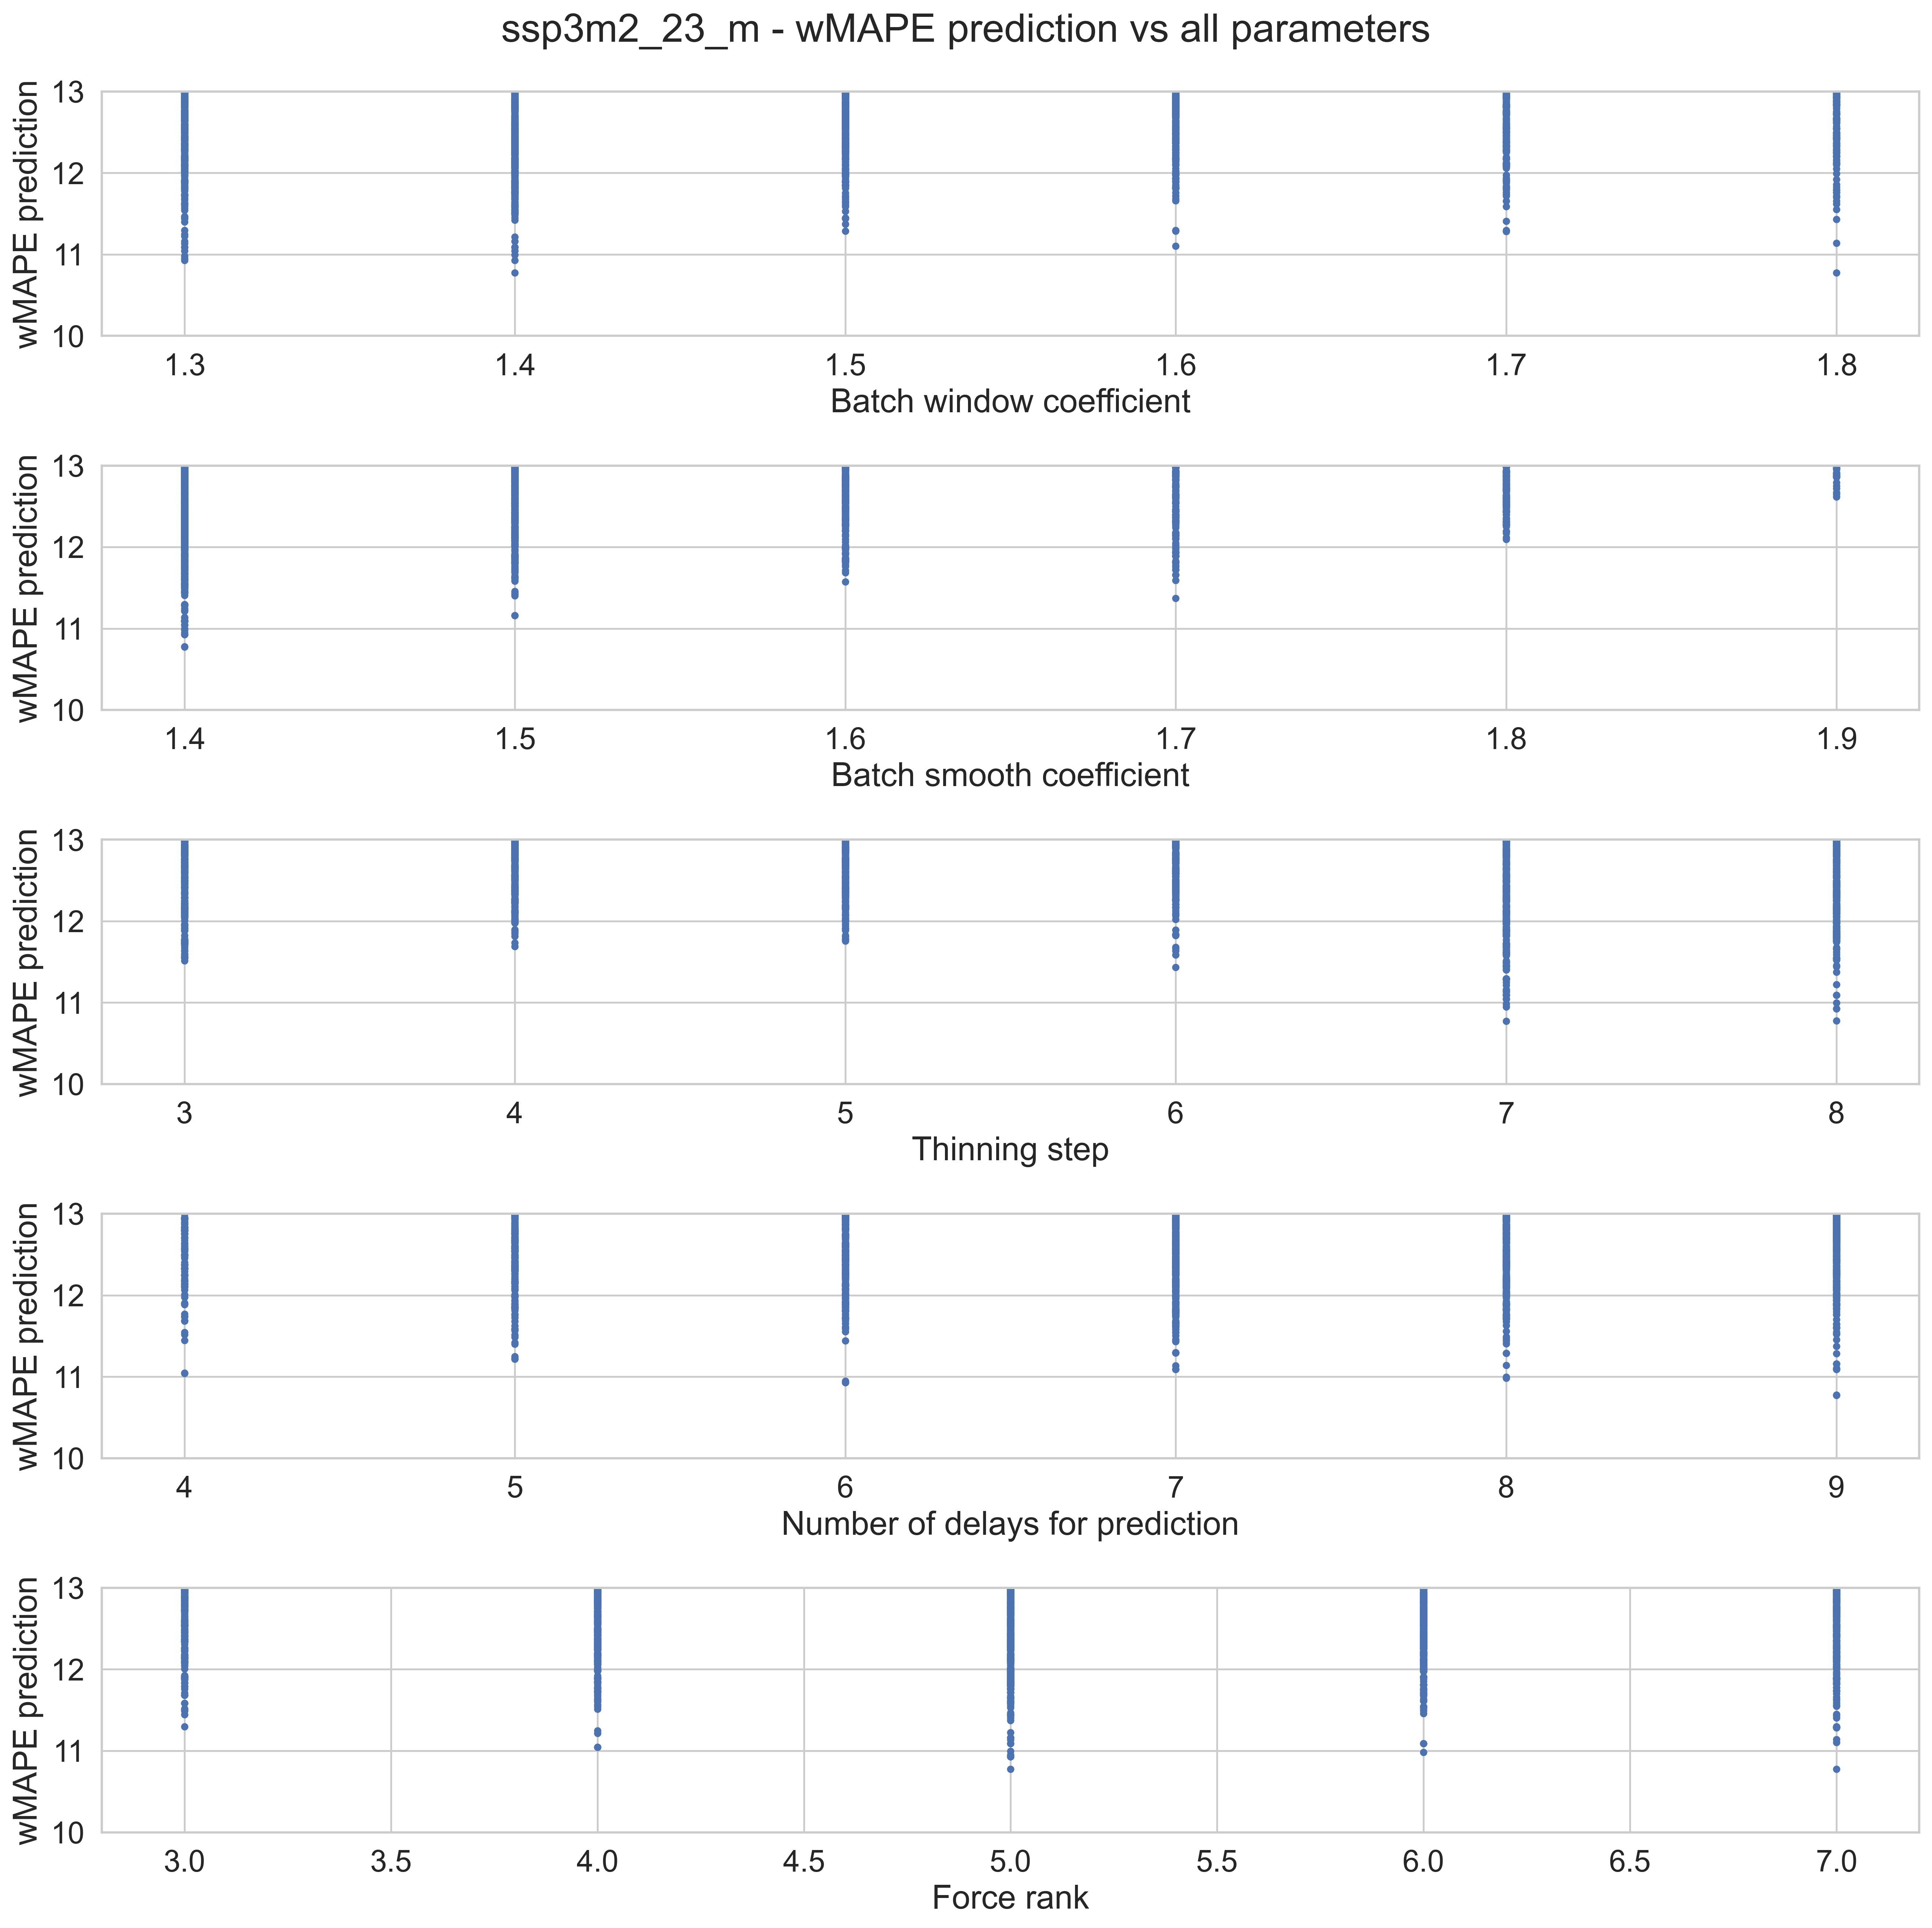

In [1183]:
# Plot wmape prediction vs all parameters - predict_step, predict_horizon, num_delays_predict, force_rank
batch_wnd_coeff, batch_smooth_coeff, thin_step, predict_horizon, num_delays_predict, force_rank = zip(*optim_results['params'])
fig, ax = plt.subplots(nrows=5, ncols=1, figsize=(15, 15), dpi=360)
ax[0].plot(batch_wnd_coeff, optim_results['wmape_pred'], '.')
ax[0].set_xlabel('Batch window coefficient')
ax[0].set_ylabel('wMAPE prediction')
ax[1].plot(batch_smooth_coeff, optim_results['wmape_pred'], '.')
ax[1].set_xlabel('Batch smooth coefficient')
ax[1].set_ylabel('wMAPE prediction')
ax[2].plot(thin_step, optim_results['wmape_pred'], '.')
ax[2].set_xlabel('Thinning step')
ax[2].set_ylabel('wMAPE prediction')
ax[3].plot(num_delays_predict, optim_results['wmape_pred'], '.')
ax[3].set_xlabel('Number of delays for prediction')
ax[3].set_ylabel('wMAPE prediction')
ax[4].plot(force_rank, optim_results['wmape_pred'], '.')
ax[4].set_xlabel('Force rank')
ax[4].set_ylabel('wMAPE prediction')
# Add title 
fig.suptitle('ssp3m2_23_m - wMAPE prediction vs all parameters')
# Set limit to all axes
for i in range(5):
    ax[i].set_ylim([10.0, 13.0])
fig.tight_layout()